# Import Libraries

In [1]:
'''Main'''
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip

'''Data Viz'''
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
color = sns.color_palette()
%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

'''Algos'''
import lightgbm as lgb

'''TensorFlow and Keras'''
import tensorflow as tf
from tensorflow import keras
K = keras.backend

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization, Input, Lambda
from tensorflow.keras import regularizers
from tensorflow.keras.losses import mse, binary_crossentropy

## Check library versions & set seed

In [2]:
import sys, sklearn
print(f'sklearn    {sklearn.__version__}')
print(f'tensorflow {tf.__version__}')
print(f'keras      {keras.__version__}')
print(f'numpy      {np.__version__}')

sklearn    1.6.1
tensorflow 2.18.0
keras      3.8.0
numpy      2.2.6


In [3]:
# To make the output stable across runs
tf.random.set_seed(42)
np.random.seed(42)

In [4]:
# Check use of GPU
if tf.test.gpu_device_name(): 
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF, if GPU is available.")

Please install GPU version of TF, if GPU is available.


# Data Preparation 

## Load the data

In [5]:
current_path = os.getcwd()
file = os.path.sep.join(['', 'datasets', 'credit_card_data', 'credit_card.csv'])
data = pd.read_csv(current_path + file)

In [8]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
dataX = data.copy().drop(['Class','Time'],axis=1)
dataY = data['Class'].copy()

## Split into train and test

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
                                    dataX, dataY, test_size=0.33, 
                                    random_state=2018, stratify=dataY)

## Scale the data

In [10]:
# Suppress warnings
pd.set_option('mode.chained_assignment', None)

featuresToScale = dataX.columns
sX = pp.StandardScaler(copy=True, with_mean=True, with_std=True)
X_train.loc[:,featuresToScale] = sX.fit_transform(X_train.loc[:,featuresToScale])
X_test.loc[:,featuresToScale] = sX.transform(X_test.loc[:,featuresToScale])

In [11]:
X_train_AE, X_test_AE = X_train.copy(), X_test.copy()

## Define evaluation function and plotting function

In [ ]:
# Mean square reco error
def anomalyScores(originalDF, reducedDF):       # originalDF like X_train and reducedDF like prediction from AE
    loss = np.sum((np.array(originalDF) - np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

In [14]:
def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = precision_recall_curve(preds['trueLabel'], preds['anomalyScore'])
    average_precision = average_precision_score(preds['trueLabel'], preds['anomalyScore'])
    
    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(average_precision))

    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: Area under the \
        curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()
    
    if returnPreds==True:
        return preds, average_precision

# Model One 
## Two layer complete autoencoder with linear activation

In [15]:
tf.random.set_seed(42)
np.random.seed(42)

In [17]:
print(X_train.shape)
print(X_test.shape)

(190820, 29)
(93987, 29)


In [18]:
# Call neural network API
model = Sequential()

# Apply linear activation function to input layer
# Generate hidden layer with 29 nodes, the same as the input layer
model.add(Dense(units=29, activation='linear',input_dim=29))

# Apply linear activation function to hidden layer
# Generate output layer with 29 nodes
model.add(Dense(units=29, activation='linear'))

C:\Users\meisa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
# Compile the model
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

In [ ]:
# Train the model
num_epochs = 10
batch_size = 32

history = model.fit(x=X_train_AE, y=X_train_AE,     # y is the original dataset
                    epochs=num_epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_train_AE, X_train_AE),
                    verbose=1)

Epoch 1/10
5964/5964 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.6887 - loss: 0.3113 - val_accuracy: 0.9775 - val_loss: 0.0024
Epoch 2/10
5964/5964 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9809 - loss: 0.0029 - val_accuracy: 0.9799 - val_loss: 0.0015
Epoch 3/10
5964/5964 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9890 - loss: 0.0012 - val_accuracy: 0.9808 - val_loss: 9.3552e-04
Epoch 4/10
5964/5964 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9921 - loss: 8.8829e-04 - val_accuracy: 0.9883 - val_loss: 3.0515e-04
Epoch 5/10
5964/5964 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9940 - loss: 5.5012e-04 - val_accuracy: 0.9824 - val_loss: 8.9234e-04
Epoch 6/10
5964/5964 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9930 - loss: 7.6519e-04 - val_accuracy: 0.9827 - val_loss: 8.5087e-04
Epoch 7/10
5964/5964 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.9930 - loss: 7.0679e-04 - val_accuracy: 0.9835 - val_loss: 0.0011
Epoch 8/10
5964/5964 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - ac

## Evaluate on Test Set

2938/2938 ━━━━━━━━━━━━━━━━━━━━ 1s 333us/step


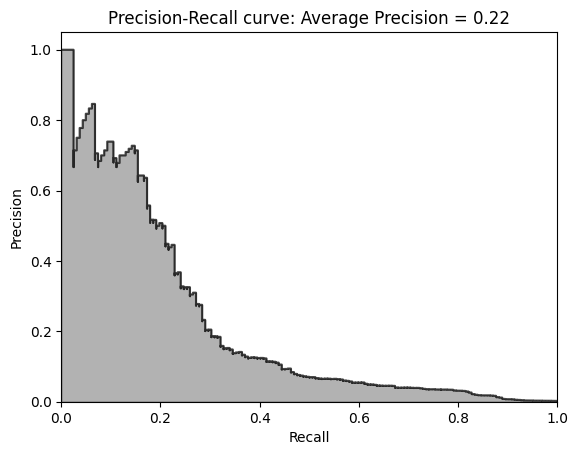

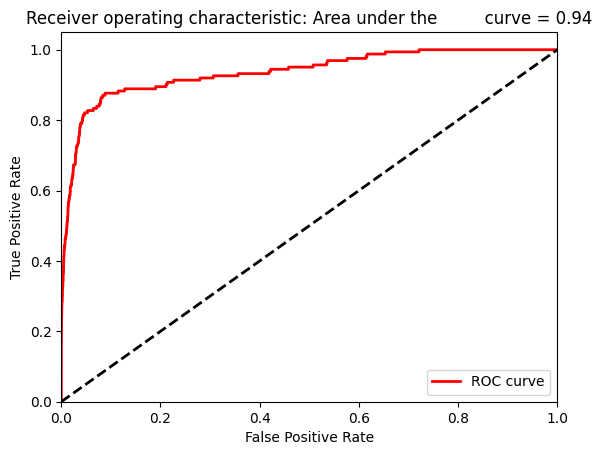

In [22]:
predictions = model.predict(X_test, verbose=1)
anomalyScoresAE = anomalyScores(X_test, predictions)
preds = plotResults(y_test, anomalyScoresAE, True)
#model.reset_states()

In [27]:
anomalyScoresAE[:5]

67353     0.000220
67626     0.000106
169699    0.000144
217315    0.000151
111420    0.000299
dtype: float64

### Separate runs

In [ ]:
# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    # Apply linear activation function to input layer
    # Generate hidden layer with 29 nodes, the same as the input layer
    model.add(Dense(units=29, activation='linear',input_dim=29))

    # Apply linear activation function to hidden layer
    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print(f'Mean average precision over 10 runs: {np.mean(test_scores)}')
[round(x,4) for x in test_scores]

In [ ]:
print(f'Mean average precision over 10 runs:   {round(np.mean(test_scores),4)}')
print(f'Coefficient of variation over 10 runs: {round(np.std(test_scores)/np.mean(test_scores),4)}')
[round(x,4) for x in test_scores]

Mean average precision over 10 runs:   0.0288
Coefficient of variation over 10 runs: 0.5141


[0.0372, 0.0166, 0.069, 0.0213, 0.0234, 0.017, 0.0195, 0.0263, 0.0247, 0.0328]

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
import numpy as np

# Set latent space size
latent_dim = 2  # You can change this

test_scores = []

for i in range(1):
    # === ENCODER ===
    inputs = Input(shape=(29,))
    hidden = Dense(29, activation='linear')(inputs)
    
    z_mean = Dense(latent_dim)(hidden)
    z_log_var = Dense(latent_dim)(hidden)

    # Reparameterization trick
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

    z = Lambda(sampling)([z_mean, z_log_var])

    # === DECODER ===
    decoder_hidden = Dense(29, activation='linear')
    decoder_output = Dense(29, activation='linear')
    
    hidden_decoded = decoder_hidden(z)
    outputs = decoder_output(hidden_decoded)

    # === VAE Model ===
    vae = Model(inputs, outputs)

    # === Loss Function ===
    reconstruction_loss = mse(inputs, outputs)
    reconstruction_loss *= 29  # multiply by input dimensions

    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(reconstruction_loss + kl_loss)

    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')

    # === Train ===
    history = vae.fit(X_train_AE, X_train_AE,
                      epochs=10,
                      batch_size=32,
                      shuffle=True,
                      validation_data=(X_train_AE, X_train_AE),
                      verbose=1)

    # === Evaluate ===
    predictions = vae.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)

print(f"Mean average precision over 10 runs: {np.mean(test_scores)}")
print([round(x, 4) for x in test_scores])


# Model Two
## Two layer undercomplete autoencoder with linear activation
## 20 nodes in hidden layer

In [28]:
tf.random.set_seed(42)
np.random.seed(42)

Epoch 1/10


C:\Users\meisa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5964/5964 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.4526 - loss: 0.4818 - val_accuracy: 0.6072 - val_loss: 0.2788
Epoch 2/10
5964/5964 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.6004 - loss: 0.2837 - val_accuracy: 0.6337 - val_loss: 0.2764
Epoch 3/10
5964/5964 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.6234 - loss: 0.2800 - val_accuracy: 0.6447 - val_loss: 0.2754
Epoch 4/10
5964/5964 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.6327 - loss: 0.2790 - val_accuracy: 0.6441 - val_loss: 0.2750
Epoch 5/10
5964/5964 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.6373 - loss: 0.2785 - val_accuracy: 0.6445 - val_loss: 0.2748
Epoch 6/10
5964/5964 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.6389 - loss: 0.2782 - val_accuracy: 0.6471 - val_loss: 0.2750
Epoch 7/10
5964/5964 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.6436 - loss: 0.2781 - val_accuracy: 0.6516 - val_loss: 0.2749
Epoch 8/10
5964/5964 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.6486 - loss: 0.2780 - val_accurac

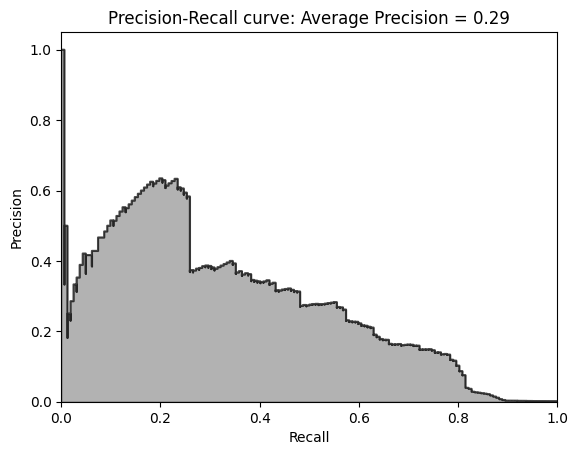

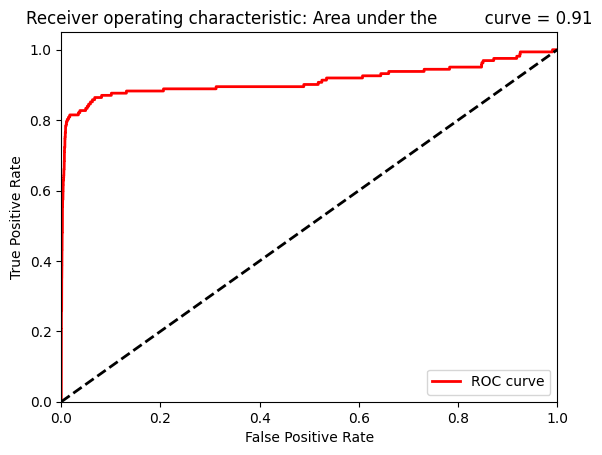

AttributeError: 'Sequential' object has no attribute 'reset_states'

In [ ]:
# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,1):
    # Call neural network API
    model = Sequential()

    # Apply linear activation function to input layer
    # Generate hidden layer with 20 nodes
    model.add(Dense(units=20, activation='linear',input_dim=29))

    # Apply linear activation function to hidden layer
    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    #model.reset_states()

print(f"Mean average precision over 10 runs: {round(np.mean(test_scores),4)}")
[round(x,4) for x in test_scores]

In [31]:
print(f"Mean average precision over 10 runs: {round(np.mean(test_scores),4)}")
[round(x,4) for x in test_scores]

Mean average precision over 10 runs: 0.2856


[np.float64(0.2856)]

## Results

In [ ]:
print(f'Mean average precision over 10 runs:   {round(np.mean(test_scores),4)}')
print(f'Coefficient of variation over 10 runs: {round(np.std(test_scores)/np.mean(test_scores),4)}')
[round(x,4) for x in test_scores]

Mean average precision over 10 runs:   0.2752
Coefficient of variation over 10 runs: 0.0225


[0.2799, 0.2837, 0.2649, 0.2822, 0.2744, 0.2674, 0.2816, 0.2711, 0.2755, 0.271]

# Model Two v2
## Two layer undercomplete autoencoder with linear activation 
## With 27 nodes this time 

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

Epoch 1/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.3209 - accuracy: 0.6425 - val_loss: 0.0365 - val_accuracy: 0.8872
Epoch 2/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0368 - accuracy: 0.8912 - val_loss: 0.0373 - val_accuracy: 0.9247
Epoch 3/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0474 - accuracy: 0.9257 - val_loss: 0.0374 - val_accuracy: 0.9512
Epoch 4/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0393 - accuracy: 0.9540 - val_loss: 0.0377 - val_accuracy: 0.9516
Epoch 5/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0382 - accuracy: 0.9545 - val_loss: 0.0363 - val_accuracy: 0.9615
Epoch 6/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0360 - accuracy: 0.9592 - val_loss: 0.0376 - val_accuracy: 0.9510
Epoch 7/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0352 - accuracy: 0.9583 - val_loss: 0.0382 - val_accurac

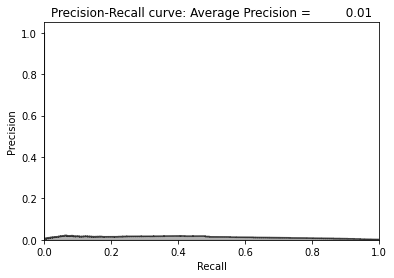

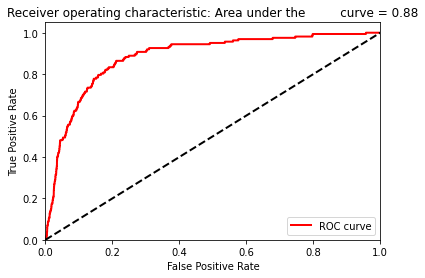

Epoch 1/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.3188 - accuracy: 0.6564 - val_loss: 0.0373 - val_accuracy: 0.9131
Epoch 2/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0402 - accuracy: 0.9055 - val_loss: 0.0358 - val_accuracy: 0.9328
Epoch 3/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0408 - accuracy: 0.9228 - val_loss: 0.0358 - val_accuracy: 0.9536
Epoch 4/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0353 - accuracy: 0.9527 - val_loss: 0.0368 - val_accuracy: 0.9379
Epoch 5/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0368 - accuracy: 0.9439 - val_loss: 0.0356 - val_accuracy: 0.9412
Epoch 6/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0357 - accuracy: 0.9494 - val_loss: 0.0362 - val_accuracy: 0.9445
Epoch 7/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0359 - accuracy: 0.9500 - val_loss: 0.0375 - val_accurac

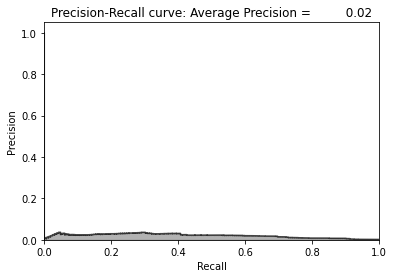

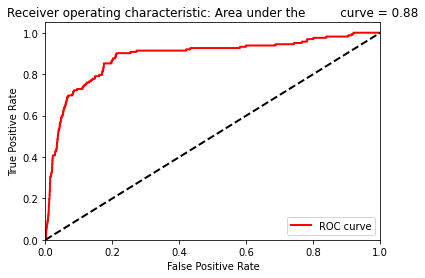

Epoch 1/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.3392 - accuracy: 0.6583 - val_loss: 0.0374 - val_accuracy: 0.9221
Epoch 2/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0401 - accuracy: 0.9374 - val_loss: 0.0365 - val_accuracy: 0.9505
Epoch 3/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0455 - accuracy: 0.9475 - val_loss: 0.0371 - val_accuracy: 0.9579
Epoch 4/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0379 - accuracy: 0.9606 - val_loss: 0.0380 - val_accuracy: 0.9532
Epoch 5/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0380 - accuracy: 0.9549 - val_loss: 0.0364 - val_accuracy: 0.9642
Epoch 6/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0360 - accuracy: 0.9613 - val_loss: 0.0372 - val_accuracy: 0.9576
Epoch 7/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0348 - accuracy: 0.9600 - val_loss: 0.0367 - val_accurac

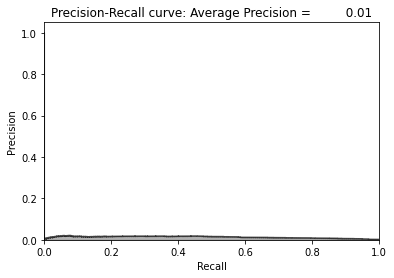

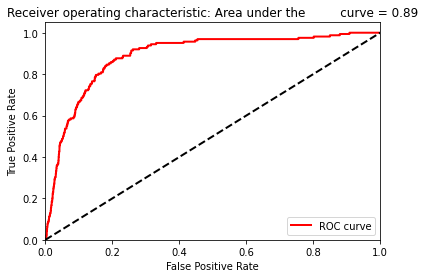

Epoch 1/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.3200 - accuracy: 0.6504 - val_loss: 0.0380 - val_accuracy: 0.9415
Epoch 2/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0396 - accuracy: 0.9543 - val_loss: 0.0369 - val_accuracy: 0.9636
Epoch 3/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0482 - accuracy: 0.9591 - val_loss: 0.0378 - val_accuracy: 0.9659
Epoch 4/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0379 - accuracy: 0.9673 - val_loss: 0.0384 - val_accuracy: 0.9575
Epoch 5/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0380 - accuracy: 0.9605 - val_loss: 0.0365 - val_accuracy: 0.9669
Epoch 6/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0361 - accuracy: 0.9614 - val_loss: 0.0383 - val_accuracy: 0.9500
Epoch 7/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0350 - accuracy: 0.9600 - val_loss: 0.0369 - val_ac

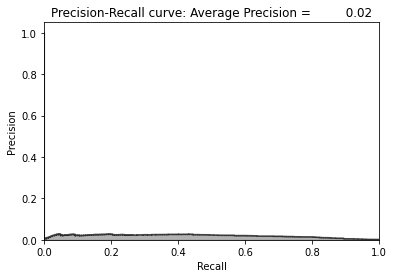

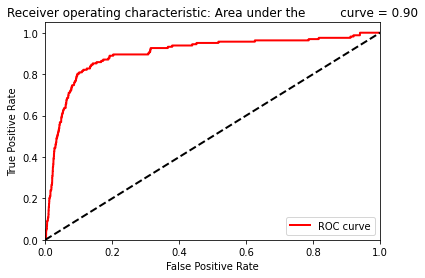

Epoch 1/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.3337 - accuracy: 0.6521 - val_loss: 0.0375 - val_accuracy: 0.9155
Epoch 2/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0404 - accuracy: 0.9305 - val_loss: 0.0369 - val_accuracy: 0.9474
Epoch 3/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0467 - accuracy: 0.9467 - val_loss: 0.0375 - val_accuracy: 0.9534
Epoch 4/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0388 - accuracy: 0.9598 - val_loss: 0.0381 - val_accuracy: 0.9586
Epoch 5/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0382 - accuracy: 0.9579 - val_loss: 0.0365 - val_accuracy: 0.9662
Epoch 6/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.0364 - accuracy: 0.9606 - val_loss: 0.0373 - val_accuracy: 0.9535
Epoch 7/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0349 - accuracy: 0.9586 - val_loss: 0.0371 - val_acc

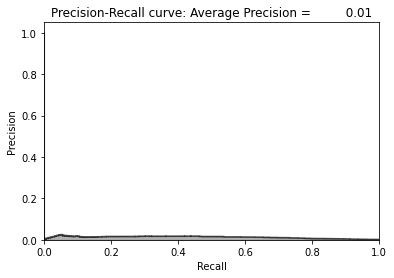

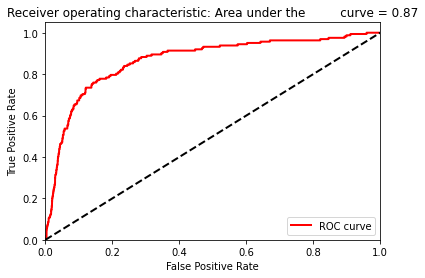

Epoch 1/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.3201 - accuracy: 0.6345 - val_loss: 0.0381 - val_accuracy: 0.8996
Epoch 2/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0395 - accuracy: 0.8891 - val_loss: 0.0362 - val_accuracy: 0.9169
Epoch 3/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0436 - accuracy: 0.9157 - val_loss: 0.0363 - val_accuracy: 0.9368
Epoch 4/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0404 - accuracy: 0.9385 - val_loss: 0.0373 - val_accuracy: 0.9443
Epoch 5/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0385 - accuracy: 0.9469 - val_loss: 0.0361 - val_accuracy: 0.9582
Epoch 6/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0366 - accuracy: 0.9551 - val_loss: 0.0372 - val_accuracy: 0.9520
Epoch 7/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0356 - accuracy: 0.9593 - val_loss: 0.0372 - val_accu

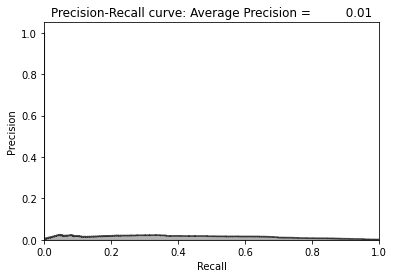

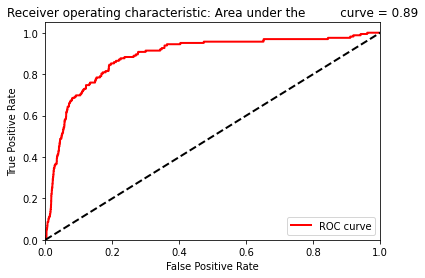

Epoch 1/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.3314 - accuracy: 0.6595 - val_loss: 0.0382 - val_accuracy: 0.8808
Epoch 2/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0401 - accuracy: 0.8860 - val_loss: 0.0361 - val_accuracy: 0.9015
Epoch 3/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0412 - accuracy: 0.9021 - val_loss: 0.0360 - val_accuracy: 0.9038
Epoch 4/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0380 - accuracy: 0.9135 - val_loss: 0.0370 - val_accuracy: 0.9152
Epoch 5/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0376 - accuracy: 0.9180 - val_loss: 0.0362 - val_accuracy: 0.9280
Epoch 6/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0372 - accuracy: 0.9300 - val_loss: 0.0375 - val_accuracy: 0.9215
Epoch 7/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0351 - accuracy: 0.9334 - val_loss: 0.0371 - val_acc

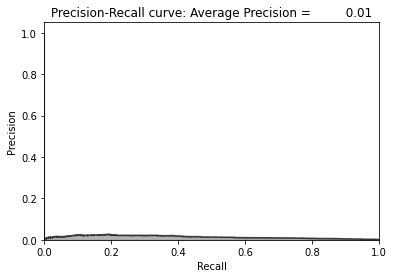

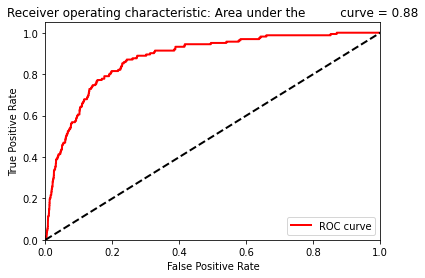

Epoch 1/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.3814 - accuracy: 0.6203 - val_loss: 0.0375 - val_accuracy: 0.9055
Epoch 2/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0387 - accuracy: 0.9122 - val_loss: 0.0356 - val_accuracy: 0.9285
Epoch 3/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0376 - accuracy: 0.9308 - val_loss: 0.0358 - val_accuracy: 0.9359
Epoch 4/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0360 - accuracy: 0.9397 - val_loss: 0.0358 - val_accuracy: 0.9446
Epoch 5/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0369 - accuracy: 0.9445 - val_loss: 0.0355 - val_accuracy: 0.9546
Epoch 6/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0354 - accuracy: 0.9557 - val_loss: 0.0356 - val_accuracy: 0.9547
Epoch 7/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0373 - accuracy: 0.9552 - val_loss: 0.0391 - val_accu

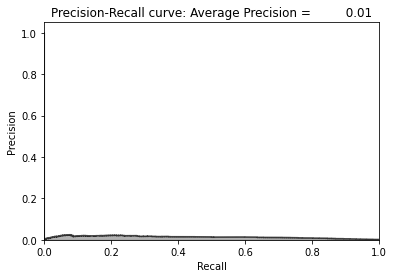

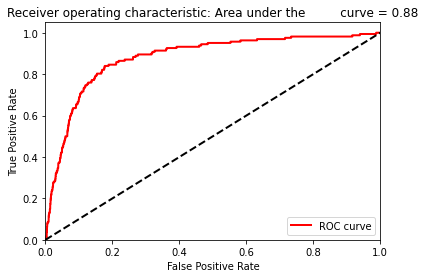

Epoch 1/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.3032 - accuracy: 0.6632 - val_loss: 0.0369 - val_accuracy: 0.9214
Epoch 2/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0399 - accuracy: 0.9375 - val_loss: 0.0366 - val_accuracy: 0.9577
Epoch 3/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0470 - accuracy: 0.9517 - val_loss: 0.0380 - val_accuracy: 0.9659
Epoch 4/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0381 - accuracy: 0.9665 - val_loss: 0.0379 - val_accuracy: 0.9620
Epoch 5/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0385 - accuracy: 0.9651 - val_loss: 0.0365 - val_accuracy: 0.9695
Epoch 6/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0362 - accuracy: 0.9641 - val_loss: 0.0370 - val_accuracy: 0.9597
Epoch 7/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0347 - accuracy: 0.9635 - val_loss: 0.0379 - val_ac

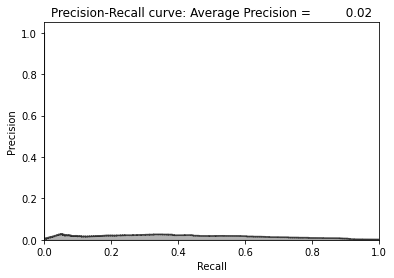

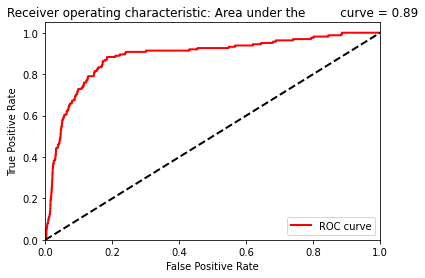

Epoch 1/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.3304 - accuracy: 0.6521 - val_loss: 0.0374 - val_accuracy: 0.9069
Epoch 2/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0394 - accuracy: 0.9077 - val_loss: 0.0358 - val_accuracy: 0.9077
Epoch 3/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0367 - accuracy: 0.9132 - val_loss: 0.0352 - val_accuracy: 0.9173
Epoch 4/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0336 - accuracy: 0.9296 - val_loss: 0.0355 - val_accuracy: 0.9140
Epoch 5/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0379 - accuracy: 0.9180 - val_loss: 0.0343 - val_accuracy: 0.9457
Epoch 6/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0312 - accuracy: 0.9466 - val_loss: 0.0354 - val_accuracy: 0.9138
Epoch 7/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0342 - accuracy: 0.9378 - val_loss: 0.0373 - val_accur

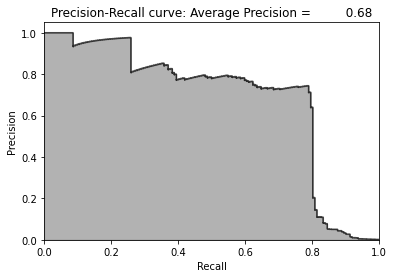

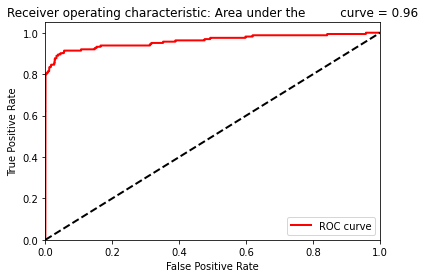

Mean average precision over 10 runs: 0.0821


[0.0129, 0.02, 0.0131, 0.0191, 0.0129, 0.0149, 0.0138, 0.0135, 0.0164, 0.6844]

In [ ]:
# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    # Apply linear activation function to input layer
    # Generate hidden layer with 27 nodes
    model.add(Dense(units=27, activation='linear',input_dim=29))

    # Apply linear activation function to hidden layer
    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print(f"Mean average precision over 10 runs: {round(np.mean(test_scores),4)}")
[round(x,4) for x in test_scores]

## Results

In [ ]:
print(f'Mean average precision over 10 runs:   {round(np.mean(test_scores),4)}')
print(f'Coefficient of variation over 10 runs: {round(np.std(test_scores)/np.mean(test_scores),4)}')
[round(x,4) for x in test_scores]

Mean average precision over 10 runs:   0.0821
Coefficient of variation over 10 runs: 2.4455


[0.0129, 0.02, 0.0131, 0.0191, 0.0129, 0.0149, 0.0138, 0.0135, 0.0164, 0.6844]

# Model Three
## Three layer undercomplete autoencoder with linear activation.
## With 28 and 27 nodes in the two hidden layers, respectively

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

Epoch 1/10


C:\Users\meisa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5964/5964 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.6468 - loss: 0.3002 - val_accuracy: 0.9043 - val_loss: 0.0392
Epoch 2/10
5964/5964 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.8853 - loss: 0.0413 - val_accuracy: 0.9087 - val_loss: 0.0392
Epoch 3/10
5964/5964 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8932 - loss: 0.0408 - val_accuracy: 0.9101 - val_loss: 0.0399
Epoch 4/10
5964/5964 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9066 - loss: 0.0408 - val_accuracy: 0.9188 - val_loss: 0.0393
Epoch 5/10
5964/5964 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9168 - loss: 0.0412 - val_accuracy: 0.9298 - val_loss: 0.0391
Epoch 6/10
5964/5964 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9291 - loss: 0.0419 - val_accuracy: 0.9412 - val_loss: 0.0388
Epoch 7/10
5964/5964 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.9404 - loss: 0.0419 - val_accuracy: 0.9450 - val_loss: 0.0383
Epoch 8/10
5964/5964 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9425 - loss: 0.0424 - val_accura

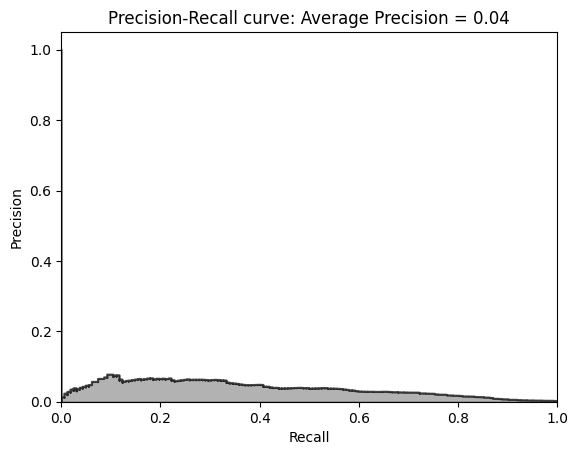

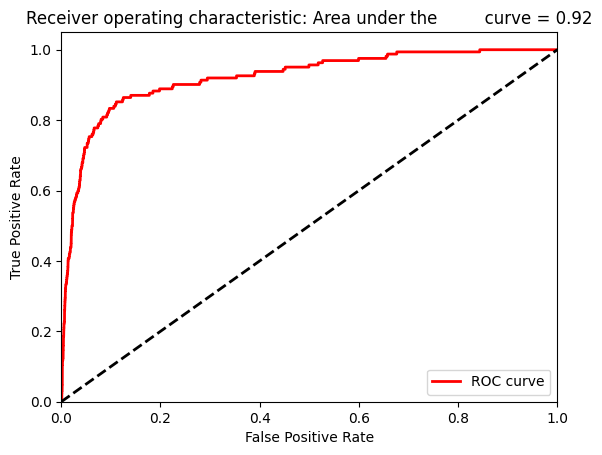

Mean average precision over 10 runs: 0.0368


[np.float64(0.0368)]

In [33]:
# 10 runs - We will capture mean of average precision
tf.random.set_seed(42)
np.random.seed(42)
test_scores = []
#for i in range(0,11):
for i in range(0,1):
    # Call neural network API
    model = Sequential()

    # Apply linear activation function to input layer
    # Generate first hidden layer with 27 nodes
    # Generate second hidden layer with 28 nodes
    model.add(Dense(units=28, activation='linear',input_dim=29))
    model.add(Dense(units=27, activation='linear'))

    # Apply linear activation function to second hidden layer
    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    #model.reset_states()

print(f"Mean average precision over 10 runs: {round(np.mean(test_scores),4)}")
[round(x,4) for x in test_scores]

## Results

In [ ]:
print(f'Mean average precision over 10 runs:   {round(np.mean(test_scores),4)}')
print(f'Coefficient of variation over 10 runs: {round(np.std(test_scores)/np.mean(test_scores),4)}')
[round(x,4) for x in test_scores]

Mean average precision over 10 runs:   0.0872
Coefficient of variation over 10 runs: 2.2049


[0.0153, 0.0167, 0.0145, 0.03, 0.0255, 0.0154, 0.6637, 0.0234, 0.045, 0.023]

# Model Four
## Four layer undercomplete autoencoder with ReLu activation
## 29 -> 27 -> 22 -> 27 -> 29

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

Epoch 1/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.7648 - accuracy: 0.4436 - val_loss: 0.6323 - val_accuracy: 0.7000
Epoch 2/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.6283 - accuracy: 0.7122 - val_loss: 0.6233 - val_accuracy: 0.7208
Epoch 3/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.6270 - accuracy: 0.7276 - val_loss: 0.6217 - val_accuracy: 0.7225
Epoch 4/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.6165 - accuracy: 0.7355 - val_loss: 0.6220 - val_accuracy: 0.7257
Epoch 5/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.6273 - accuracy: 0.7426 - val_loss: 0.6184 - val_accuracy: 0.7403
Epoch 6/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.6122 - accuracy: 0.7490 - val_loss: 0.6184 - val_accuracy: 0.7430
Epoch 7/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.6160 - accuracy: 0.7485 - val_loss: 0.6208 - val_ac

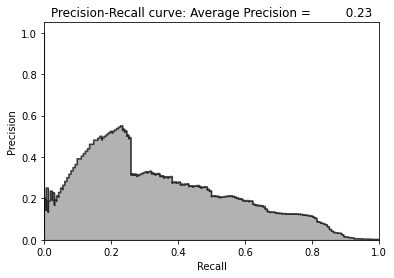

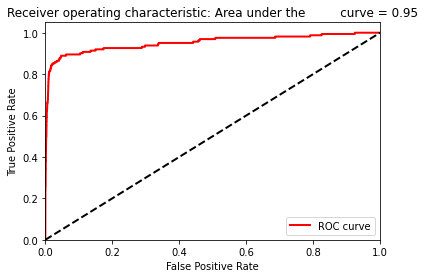

Epoch 1/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.7414 - accuracy: 0.4732 - val_loss: 0.5855 - val_accuracy: 0.7640
Epoch 2/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.5778 - accuracy: 0.7840 - val_loss: 0.5662 - val_accuracy: 0.8200
Epoch 3/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.5689 - accuracy: 0.8230 - val_loss: 0.5668 - val_accuracy: 0.8087
Epoch 4/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.5543 - accuracy: 0.8290 - val_loss: 0.5589 - val_accuracy: 0.8284
Epoch 5/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.5619 - accuracy: 0.8342 - val_loss: 0.5572 - val_accuracy: 0.8461
Epoch 6/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.5502 - accuracy: 0.8435 - val_loss: 0.5587 - val_accuracy: 0.8438
Epoch 7/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.5529 - accuracy: 0.8431 - val_loss: 0.5575 - val_ac

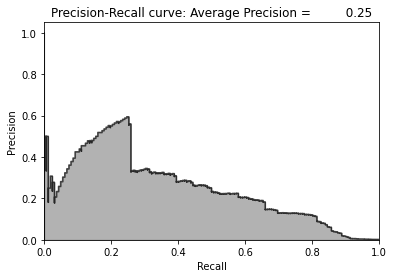

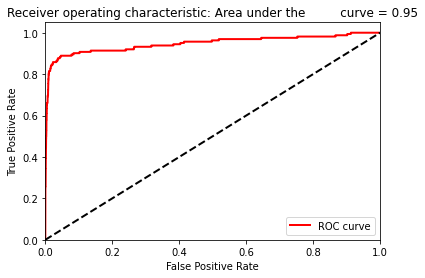

Epoch 1/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.7605 - accuracy: 0.4620 - val_loss: 0.6042 - val_accuracy: 0.7434
Epoch 2/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.5911 - accuracy: 0.7784 - val_loss: 0.5552 - val_accuracy: 0.8269
Epoch 3/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.5597 - accuracy: 0.8276 - val_loss: 0.5488 - val_accuracy: 0.8244
Epoch 4/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.5422 - accuracy: 0.8437 - val_loss: 0.5441 - val_accuracy: 0.8536
Epoch 5/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.5515 - accuracy: 0.8542 - val_loss: 0.5432 - val_accuracy: 0.8506
Epoch 6/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.5378 - accuracy: 0.8579 - val_loss: 0.5484 - val_accuracy: 0.8544
Epoch 7/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.5453 - accuracy: 0.8528 - val_loss: 0.5579 - val_ac

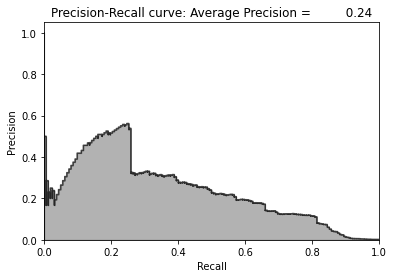

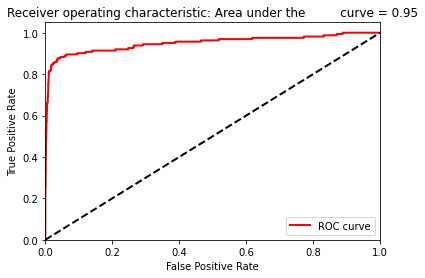

Epoch 1/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.7464 - accuracy: 0.5046 - val_loss: 0.5917 - val_accuracy: 0.8105
Epoch 2/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.5858 - accuracy: 0.8345 - val_loss: 0.5750 - val_accuracy: 0.8530
Epoch 3/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.5848 - accuracy: 0.8525 - val_loss: 0.5613 - val_accuracy: 0.8445
Epoch 4/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.5506 - accuracy: 0.8778 - val_loss: 0.5550 - val_accuracy: 0.8728
Epoch 5/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.5554 - accuracy: 0.8851 - val_loss: 0.5535 - val_accuracy: 0.8840
Epoch 6/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.5441 - accuracy: 0.8976 - val_loss: 0.5571 - val_accuracy: 0.8486
Epoch 7/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.5452 - accuracy: 0.9023 - val_loss: 0.5499 - val_ac

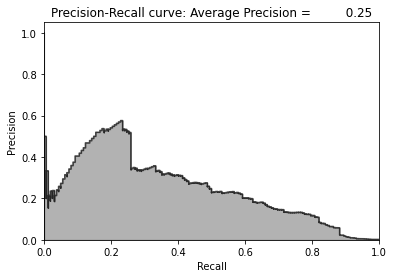

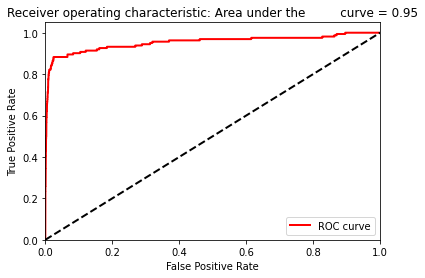

Epoch 1/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.7518 - accuracy: 0.4986 - val_loss: 0.5950 - val_accuracy: 0.7868
Epoch 2/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.5900 - accuracy: 0.8051 - val_loss: 0.5843 - val_accuracy: 0.8154
Epoch 3/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.5828 - accuracy: 0.8278 - val_loss: 0.5761 - val_accuracy: 0.8248
Epoch 4/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.5680 - accuracy: 0.8343 - val_loss: 0.5720 - val_accuracy: 0.8532
Epoch 5/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.5742 - accuracy: 0.8476 - val_loss: 0.5702 - val_accuracy: 0.8501
Epoch 6/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.5634 - accuracy: 0.8577 - val_loss: 0.5713 - val_accuracy: 0.8436
Epoch 7/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.5655 - accuracy: 0.8608 - val_loss: 0.5717 - val_ac

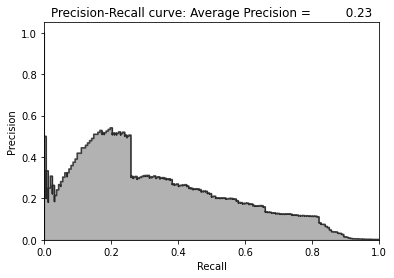

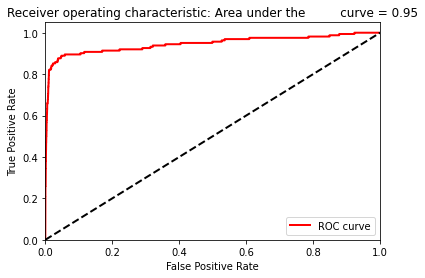

Epoch 1/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.7448 - accuracy: 0.4881 - val_loss: 0.5892 - val_accuracy: 0.7705
Epoch 2/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.5845 - accuracy: 0.7938 - val_loss: 0.5703 - val_accuracy: 0.8245
Epoch 3/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.5757 - accuracy: 0.8273 - val_loss: 0.5682 - val_accuracy: 0.8396
Epoch 4/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.5590 - accuracy: 0.8400 - val_loss: 0.5771 - val_accuracy: 0.8099
Epoch 5/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.5684 - accuracy: 0.8430 - val_loss: 0.5636 - val_accuracy: 0.8493
Epoch 6/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.5569 - accuracy: 0.8556 - val_loss: 0.5677 - val_accuracy: 0.8376
Epoch 7/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.5589 - accuracy: 0.8624 - val_loss: 0.5625 - val_ac

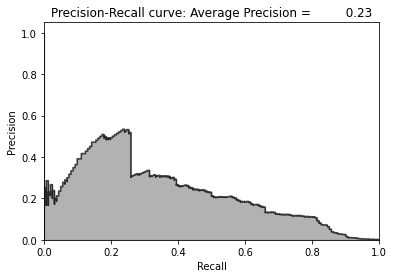

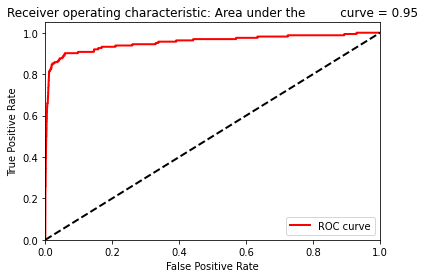

Epoch 1/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.7871 - accuracy: 0.4651 - val_loss: 0.6427 - val_accuracy: 0.7778
Epoch 2/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.6398 - accuracy: 0.7991 - val_loss: 0.6320 - val_accuracy: 0.8188
Epoch 3/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.6415 - accuracy: 0.8267 - val_loss: 0.6286 - val_accuracy: 0.8243
Epoch 4/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.6200 - accuracy: 0.8414 - val_loss: 0.6249 - val_accuracy: 0.8452
Epoch 5/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.6398 - accuracy: 0.8240 - val_loss: 0.6345 - val_accuracy: 0.8304
Epoch 6/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.6273 - accuracy: 0.8286 - val_loss: 0.6342 - val_accuracy: 0.8258
Epoch 7/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.6310 - accuracy: 0.8325 - val_loss: 0.6384 - val_ac

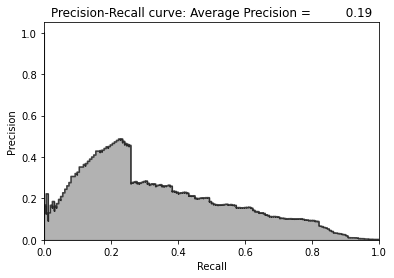

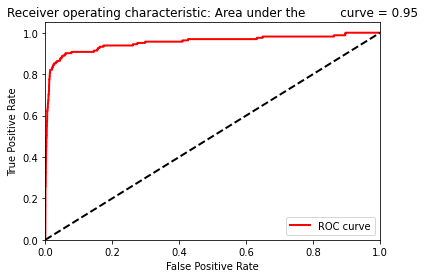

Epoch 1/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.7682 - accuracy: 0.5059 - val_loss: 0.6147 - val_accuracy: 0.8106
Epoch 2/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.6062 - accuracy: 0.8525 - val_loss: 0.5867 - val_accuracy: 0.8936
Epoch 3/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.5918 - accuracy: 0.8832 - val_loss: 0.5907 - val_accuracy: 0.8569
Epoch 4/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.5802 - accuracy: 0.8891 - val_loss: 0.5830 - val_accuracy: 0.8897
Epoch 5/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.5947 - accuracy: 0.8844 - val_loss: 0.5821 - val_accuracy: 0.8957
Epoch 6/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.5792 - accuracy: 0.8938 - val_loss: 0.5812 - val_accuracy: 0.8930
Epoch 7/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.5823 - accuracy: 0.8926 - val_loss: 0.5928 - val_ac

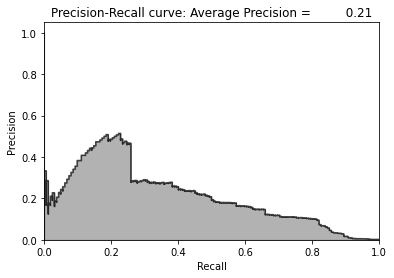

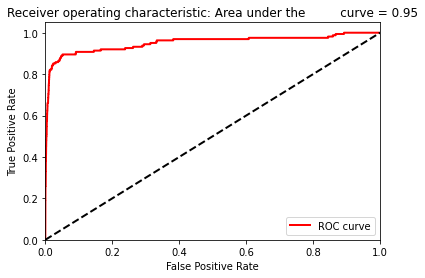

Epoch 1/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.7609 - accuracy: 0.4881 - val_loss: 0.6121 - val_accuracy: 0.7783
Epoch 2/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.6063 - accuracy: 0.8021 - val_loss: 0.6108 - val_accuracy: 0.8282
Epoch 3/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.6082 - accuracy: 0.8265 - val_loss: 0.5950 - val_accuracy: 0.8263
Epoch 4/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.5905 - accuracy: 0.8361 - val_loss: 0.5867 - val_accuracy: 0.8493
Epoch 5/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.5907 - accuracy: 0.8441 - val_loss: 0.5861 - val_accuracy: 0.8408
Epoch 6/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.5812 - accuracy: 0.8491 - val_loss: 0.5841 - val_accuracy: 0.8580
Epoch 7/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.5816 - accuracy: 0.8563 - val_loss: 0.5862 - val_ac

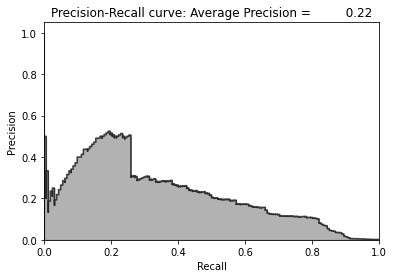

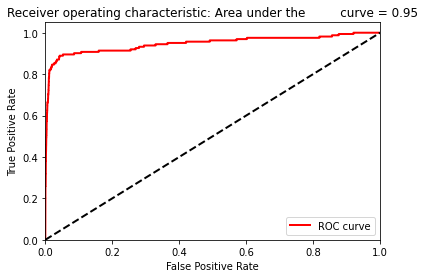

Epoch 1/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.7575 - accuracy: 0.4806 - val_loss: 0.6120 - val_accuracy: 0.7313
Epoch 2/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.6058 - accuracy: 0.7513 - val_loss: 0.5911 - val_accuracy: 0.7741
Epoch 3/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.5987 - accuracy: 0.7900 - val_loss: 0.5878 - val_accuracy: 0.7875
Epoch 4/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.5744 - accuracy: 0.8095 - val_loss: 0.5760 - val_accuracy: 0.8019
Epoch 5/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.5740 - accuracy: 0.8164 - val_loss: 0.5571 - val_accuracy: 0.8411
Epoch 6/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.5525 - accuracy: 0.8357 - val_loss: 0.5545 - val_accuracy: 0.8443
Epoch 7/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.5539 - accuracy: 0.8395 - val_loss: 0.5574 - val_ac

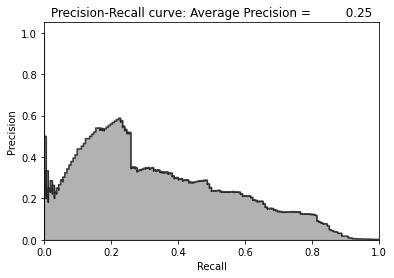

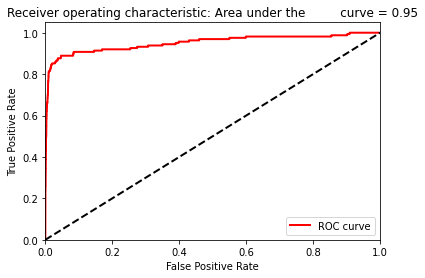

Mean average precision over 10 runs: 0.2306


[0.2293, 0.2492, 0.2382, 0.2484, 0.2316, 0.2273, 0.1948, 0.2115, 0.223, 0.2526]

In [ ]:
# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    # Apply ReLu throughout
    # Generate first hidden layer with 27 nodes
    # Generate second hidden layer with 22 nodes
    model.add(Dense(units=27, activation='relu',input_dim=29))
    model.add(Dense(units=22, activation='relu'))

    # Apply ReLu throughout
    # Generate third hidden layer with 27 nodes
    # Generate output layer with 29 nodes
    model.add(Dense(units=27, activation='relu'))
    model.add(Dense(units=29, activation='relu'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print(f"Mean average precision over 10 runs: {round(np.mean(test_scores),4)}")
[round(x,4) for x in test_scores]

## Results

In [ ]:
print(f'Mean average precision over 10 runs:   {round(np.mean(test_scores),4)}')
print(f'Coefficient of variation over 10 runs: {round(np.std(test_scores)/np.mean(test_scores),4)}')
[round(x,4) for x in test_scores]

Mean average precision over 10 runs:   0.2306
Coefficient of variation over 10 runs: 0.0741


[0.2293, 0.2492, 0.2382, 0.2484, 0.2316, 0.2273, 0.1948, 0.2115, 0.223, 0.2526]

# Model Five
## Two layer overcomplete autoencoder with linear activation
## 29 -> 40 -> 29

In [34]:
tf.random.set_seed(42)
np.random.seed(42)

Epoch 1/10


C:\Users\meisa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5964/5964 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.8068 - loss: 0.2025 - val_accuracy: 0.9655 - val_loss: 0.0047
Epoch 2/10
5964/5964 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9897 - loss: 0.0015 - val_accuracy: 0.9845 - val_loss: 8.3095e-04
Epoch 3/10
5964/5964 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9909 - loss: 0.0013 - val_accuracy: 0.9850 - val_loss: 0.0011
Epoch 4/10
5964/5964 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9918 - loss: 0.0012 - val_accuracy: 0.9813 - val_loss: 0.0017
Epoch 5/10
5964/5964 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9925 - loss: 0.0011 - val_accuracy: 0.9831 - val_loss: 0.0014
Epoch 6/10
5964/5964 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9919 - loss: 0.0012 - val_accuracy: 0.9843 - val_loss: 9.6368e-04
Epoch 7/10
5964/5964 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9925 - loss: 0.0011 - val_accuracy: 0.9818 - val_loss: 0.0011
Epoch 8/10
5964/5964 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9917 - loss: 0.0013 - val

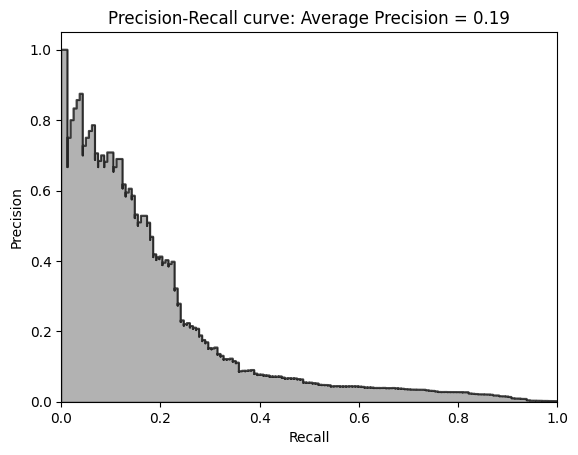

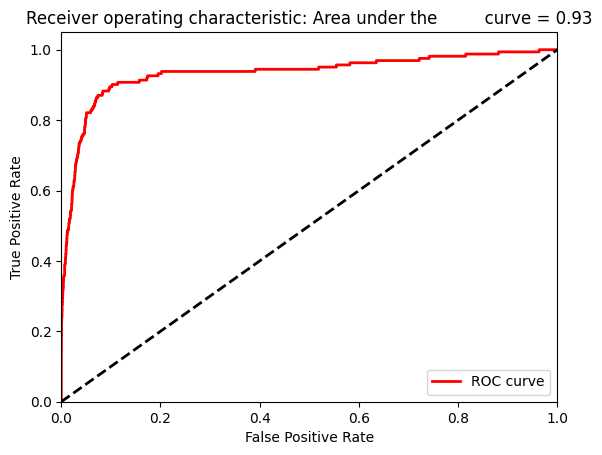

AttributeError: 'Sequential' object has no attribute 'reset_states'

In [35]:
# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,1):
    # Call neural network API
    model = Sequential()

    # Apply linear activation function throughout
    # Generate first hidden layer with 40 nodes
    model.add(Dense(units=40, activation='linear',input_dim=29))

    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    #model.reset_states()
    
print(f"Mean average precision over 10 runs: {round(np.mean(test_scores),4)}")
[round(x,4) for x in test_scores]

## Results

In [ ]:
print(f'Mean average precision over 10 runs:   {round(np.mean(test_scores),4)}')
print(f'Coefficient of variation over 10 runs: {round(np.std(test_scores)/np.mean(test_scores),4)}')
[round(x,4) for x in test_scores]

Mean average precision over 10 runs:   0.0362
Coefficient of variation over 10 runs: 0.3885


[0.0226,
 0.0259,
 0.0469,
 0.0233,
 0.0467,
 0.0167,
 0.0349,
 0.0419,
 0.0373,
 0.0658]

# Model Six
## Two layer overcomplete autoencoder with linear activation and dropout
## 29 -> 40 -> 29
## Dropout percentage: 10%

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

Epoch 1/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.2984 - accuracy: 0.6287 - val_loss: 0.0101 - val_accuracy: 0.9635
Epoch 2/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0771 - accuracy: 0.7832 - val_loss: 0.0077 - val_accuracy: 0.9731
Epoch 3/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0773 - accuracy: 0.7832 - val_loss: 0.0091 - val_accuracy: 0.9727
Epoch 4/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0744 - accuracy: 0.7827 - val_loss: 0.0091 - val_accuracy: 0.9688
Epoch 5/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0771 - accuracy: 0.7835 - val_loss: 0.0075 - val_accuracy: 0.9739
Epoch 6/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0760 - accuracy: 0.7846 - val_loss: 0.0074 - val_accuracy: 0.9721
Epoch 7/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0757 - accuracy: 0.7854 - val_loss: 0.0085 - val_accurac

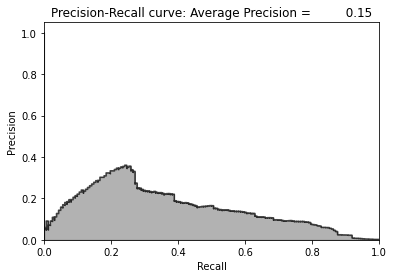

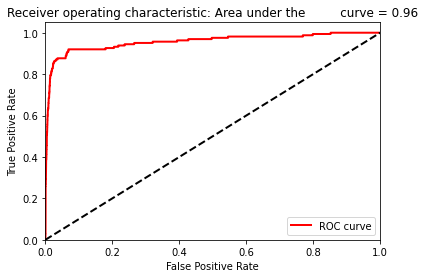

Epoch 1/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.3124 - accuracy: 0.6303 - val_loss: 0.0098 - val_accuracy: 0.9694
Epoch 2/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0767 - accuracy: 0.7856 - val_loss: 0.0083 - val_accuracy: 0.9704
Epoch 3/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0762 - accuracy: 0.7865 - val_loss: 0.0093 - val_accuracy: 0.9719
Epoch 4/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0761 - accuracy: 0.7862 - val_loss: 0.0103 - val_accuracy: 0.9639
Epoch 5/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0768 - accuracy: 0.7868 - val_loss: 0.0075 - val_accuracy: 0.9728
Epoch 6/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0751 - accuracy: 0.7883 - val_loss: 0.0093 - val_accuracy: 0.9678
Epoch 7/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0776 - accuracy: 0.7860 - val_loss: 0.0096 - val_accuracy

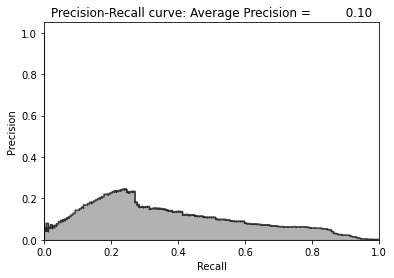

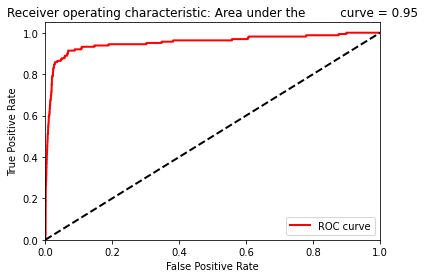

Epoch 1/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.3070 - accuracy: 0.6297 - val_loss: 0.0093 - val_accuracy: 0.9671
Epoch 2/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0766 - accuracy: 0.7882 - val_loss: 0.0080 - val_accuracy: 0.9702
Epoch 3/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0769 - accuracy: 0.7887 - val_loss: 0.0092 - val_accuracy: 0.9733
Epoch 4/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0743 - accuracy: 0.7868 - val_loss: 0.0099 - val_accuracy: 0.9647
Epoch 5/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0775 - accuracy: 0.7862 - val_loss: 0.0079 - val_accuracy: 0.9742
Epoch 6/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0745 - accuracy: 0.7896 - val_loss: 0.0089 - val_accuracy: 0.9706
Epoch 7/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0778 - accuracy: 0.7865 - val_loss: 0.0084 - val_accura

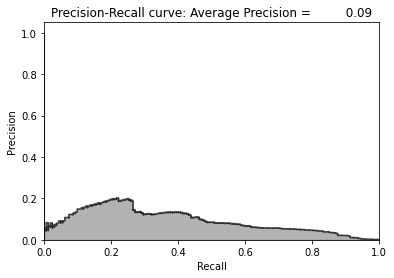

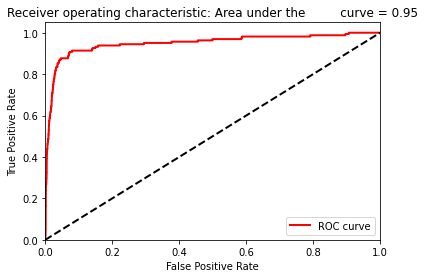

Epoch 1/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.3393 - accuracy: 0.6201 - val_loss: 0.0091 - val_accuracy: 0.9690
Epoch 2/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0752 - accuracy: 0.7860 - val_loss: 0.0081 - val_accuracy: 0.9725
Epoch 3/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0759 - accuracy: 0.7847 - val_loss: 0.0082 - val_accuracy: 0.9740
Epoch 4/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0742 - accuracy: 0.7863 - val_loss: 0.0089 - val_accuracy: 0.9665
Epoch 5/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0798 - accuracy: 0.7827 - val_loss: 0.0071 - val_accuracy: 0.9762
Epoch 6/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0746 - accuracy: 0.7865 - val_loss: 0.0084 - val_accuracy: 0.9677
Epoch 7/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0763 - accuracy: 0.7827 - val_loss: 0.0073 - val_accurac

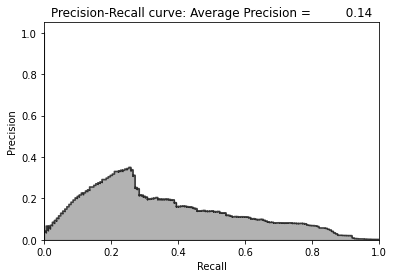

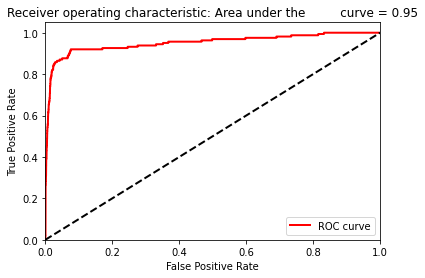

Epoch 1/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.3210 - accuracy: 0.6188 - val_loss: 0.0093 - val_accuracy: 0.9704
Epoch 2/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0763 - accuracy: 0.7866 - val_loss: 0.0078 - val_accuracy: 0.9743
Epoch 3/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0757 - accuracy: 0.7863 - val_loss: 0.0083 - val_accuracy: 0.9732
Epoch 4/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0733 - accuracy: 0.7865 - val_loss: 0.0113 - val_accuracy: 0.9624
Epoch 5/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0785 - accuracy: 0.7826 - val_loss: 0.0076 - val_accuracy: 0.9757
Epoch 6/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0749 - accuracy: 0.7866 - val_loss: 0.0089 - val_accuracy: 0.9698
Epoch 7/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0767 - accuracy: 0.7852 - val_loss: 0.0075 - val_accuracy

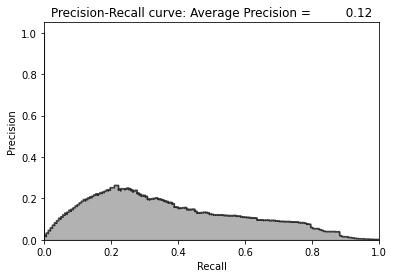

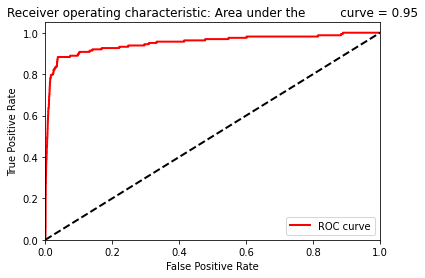

Epoch 1/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.3324 - accuracy: 0.6174 - val_loss: 0.0096 - val_accuracy: 0.9675
Epoch 2/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0772 - accuracy: 0.7850 - val_loss: 0.0075 - val_accuracy: 0.9751
Epoch 3/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0770 - accuracy: 0.7866 - val_loss: 0.0092 - val_accuracy: 0.9710
Epoch 4/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.0745 - accuracy: 0.7875 - val_loss: 0.0093 - val_accuracy: 0.9684
Epoch 5/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0762 - accuracy: 0.7855 - val_loss: 0.0071 - val_accuracy: 0.9755
Epoch 6/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0743 - accuracy: 0.7873 - val_loss: 0.0096 - val_accuracy: 0.9660
Epoch 7/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0771 - accuracy: 0.7836 - val_loss: 0.0081 - val_accurac

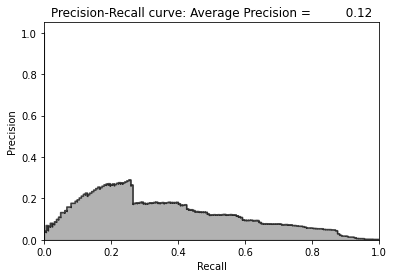

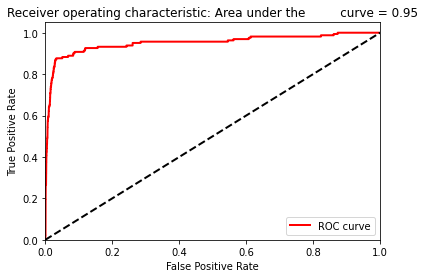

Epoch 1/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.3154 - accuracy: 0.6137 - val_loss: 0.0088 - val_accuracy: 0.9717
Epoch 2/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0773 - accuracy: 0.7849 - val_loss: 0.0077 - val_accuracy: 0.9716
Epoch 3/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0763 - accuracy: 0.7868 - val_loss: 0.0088 - val_accuracy: 0.9733
Epoch 4/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0751 - accuracy: 0.7884 - val_loss: 0.0107 - val_accuracy: 0.9672
Epoch 5/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0776 - accuracy: 0.7850 - val_loss: 0.0076 - val_accuracy: 0.9748
Epoch 6/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0759 - accuracy: 0.7845 - val_loss: 0.0077 - val_accuracy: 0.9739
Epoch 7/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0758 - accuracy: 0.7842 - val_loss: 0.0085 - val_accura

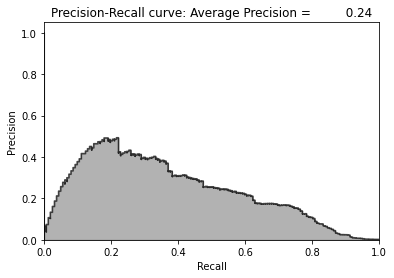

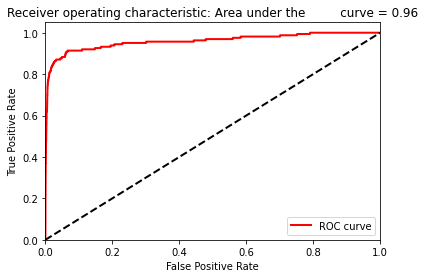

Epoch 1/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.3157 - accuracy: 0.6396 - val_loss: 0.0091 - val_accuracy: 0.9680
Epoch 2/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0765 - accuracy: 0.7870 - val_loss: 0.0077 - val_accuracy: 0.9744
Epoch 3/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0762 - accuracy: 0.7884 - val_loss: 0.0082 - val_accuracy: 0.9723
Epoch 4/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0741 - accuracy: 0.7852 - val_loss: 0.0094 - val_accuracy: 0.9703
Epoch 5/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0786 - accuracy: 0.7860 - val_loss: 0.0075 - val_accuracy: 0.9771
Epoch 6/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0753 - accuracy: 0.7870 - val_loss: 0.0076 - val_accuracy: 0.9719
Epoch 7/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0764 - accuracy: 0.7878 - val_loss: 0.0090 - val_accuracy

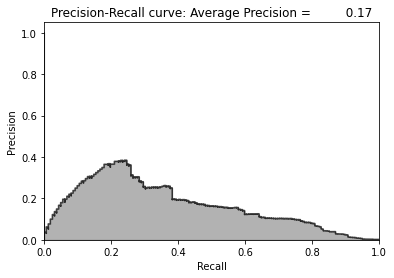

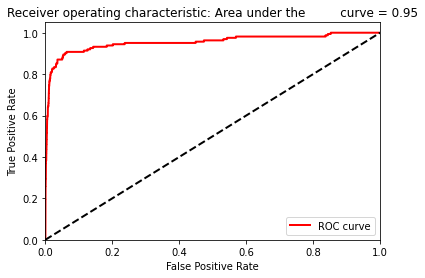

Epoch 1/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.3057 - accuracy: 0.6235 - val_loss: 0.0088 - val_accuracy: 0.9673
Epoch 2/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0776 - accuracy: 0.7856 - val_loss: 0.0079 - val_accuracy: 0.9723
Epoch 3/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0766 - accuracy: 0.7863 - val_loss: 0.0087 - val_accuracy: 0.9730
Epoch 4/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0732 - accuracy: 0.7872 - val_loss: 0.0090 - val_accuracy: 0.9690
Epoch 5/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0770 - accuracy: 0.7847 - val_loss: 0.0074 - val_accuracy: 0.9727
Epoch 6/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.0762 - accuracy: 0.7843 - val_loss: 0.0080 - val_accuracy: 0.9711
Epoch 7/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0775 - accuracy: 0.7832 - val_loss: 0.0080 - val_accurac

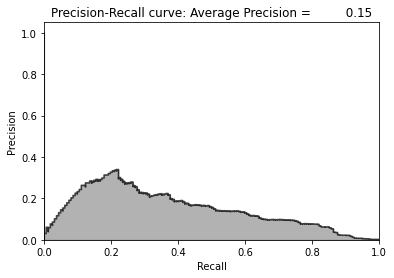

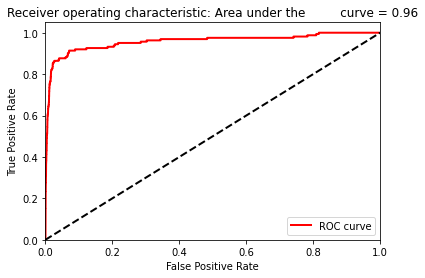

Epoch 1/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.3187 - accuracy: 0.6286 - val_loss: 0.0092 - val_accuracy: 0.9706
Epoch 2/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0773 - accuracy: 0.7853 - val_loss: 0.0078 - val_accuracy: 0.9685
Epoch 3/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0772 - accuracy: 0.7864 - val_loss: 0.0082 - val_accuracy: 0.9750
Epoch 4/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0742 - accuracy: 0.7875 - val_loss: 0.0095 - val_accuracy: 0.9682
Epoch 5/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0787 - accuracy: 0.7878 - val_loss: 0.0072 - val_accuracy: 0.9772
Epoch 6/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0762 - accuracy: 0.7864 - val_loss: 0.0080 - val_accuracy: 0.9723
Epoch 7/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0769 - accuracy: 0.7856 - val_loss: 0.0076 - val_accurac

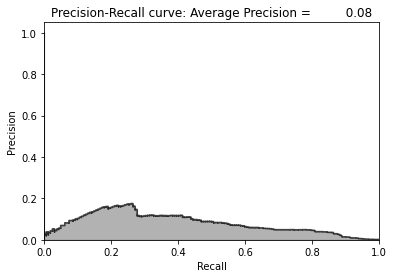

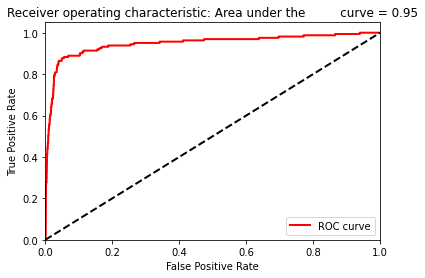

Mean average precision over 10 runs: 0.1372


[0.1539,
 0.1048,
 0.0913,
 0.1385,
 0.1235,
 0.1244,
 0.2411,
 0.1668,
 0.1482,
 0.0798]

In [ ]:
# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    model.add(Dense(units=40, activation='linear',input_dim=29))
    model.add(Dropout(0.10))

    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print(f"Mean average precision over 10 runs: {round(np.mean(test_scores),4)}")
[round(x,4) for x in test_scores]

## Results

In [ ]:
print(f'Mean average precision over 10 runs:   {round(np.mean(test_scores),4)}')
print(f'Coefficient of variation over 10 runs: {round(np.std(test_scores)/np.mean(test_scores),4)}')
[round(x,4) for x in test_scores]

Mean average precision over 10 runs:   0.1372
Coefficient of variation over 10 runs: 0.3167


[0.1539,
 0.1048,
 0.0913,
 0.1385,
 0.1235,
 0.1244,
 0.2411,
 0.1668,
 0.1482,
 0.0798]

# Model Seven
## Two layer sparse overcomplete autoencoder with linear activation
## 29 -> 40 -> 29

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

Epoch 1/10


C:\Users\meisa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5964/5964 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.7798 - loss: 0.3083 - val_accuracy: 0.9514 - val_loss: 0.0463
Epoch 2/10
5964/5964 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9811 - loss: 0.0343 - val_accuracy: 0.9448 - val_loss: 0.0321
Epoch 3/10
5964/5964 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9809 - loss: 0.0240 - val_accuracy: 0.9406 - val_loss: 0.0329
Epoch 4/10
5964/5964 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9787 - loss: 0.0211 - val_accuracy: 0.9333 - val_loss: 0.0309
Epoch 5/10
5964/5964 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9781 - loss: 0.0195 - val_accuracy: 0.9221 - val_loss: 0.0335
Epoch 6/10
5964/5964 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9770 - loss: 0.0185 - val_accuracy: 0.9313 - val_loss: 0.0300
Epoch 7/10
5964/5964 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9758 - loss: 0.0188 - val_accuracy: 0.9128 - val_loss: 0.0417
Epoch 8/10
5964/5964 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9758 - loss: 0.0183 - val_accurac

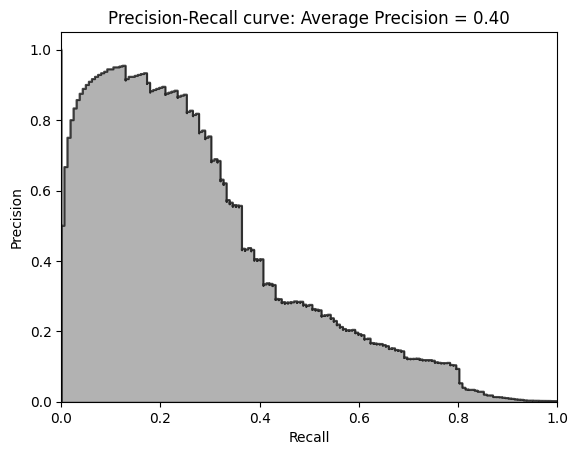

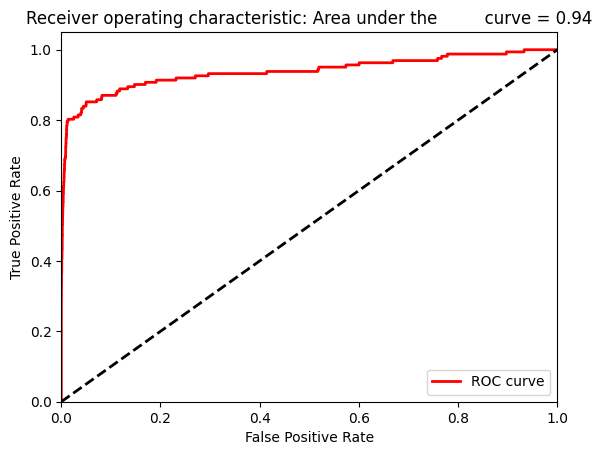

Mean average precision over 10 runs: 0.4001


[np.float64(0.4001)]

In [36]:
# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,1):
    # Call neural network API
    model = Sequential()

    model.add(Dense(units=40, activation='linear',  activity_regularizer=regularizers.l1(10e-5), input_dim=29))

    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    #model.reset_states()

print(f"Mean average precision over 10 runs: {round(np.mean(test_scores),4)}")
[round(x,4) for x in test_scores]

## Results

In [ ]:
print(f'Mean average precision over 10 runs:   {round(np.mean(test_scores),4)}')
print(f'Coefficient of variation over 10 runs: {round(np.std(test_scores)/np.mean(test_scores),4)}')
[round(x,4) for x in test_scores]

Mean average precision over 10 runs:   0.0334
Coefficient of variation over 10 runs: 0.2375


[0.0227, 0.0438, 0.0229, 0.0462, 0.0307, 0.0293, 0.042, 0.0296, 0.0367, 0.0303]

# Model Eight
## Two layer sparse overcomplete autoencoder with linear activation and dropout
## 29 -> 40 -> 29  
## Dropout percentage: 5%

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

Epoch 1/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.2588 - accuracy: 0.6891 - val_loss: 0.0079 - val_accuracy: 0.9656
Epoch 2/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0412 - accuracy: 0.8589 - val_loss: 0.0051 - val_accuracy: 0.9793
Epoch 3/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0398 - accuracy: 0.8616 - val_loss: 0.0061 - val_accuracy: 0.9774
Epoch 4/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0391 - accuracy: 0.8590 - val_loss: 0.0058 - val_accuracy: 0.9779
Epoch 5/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0405 - accuracy: 0.8593 - val_loss: 0.0043 - val_accuracy: 0.9799
Epoch 6/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0399 - accuracy: 0.8601 - val_loss: 0.0052 - val_accuracy: 0.9767
Epoch 7/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0394 - accuracy: 0.8627 - val_loss: 0.0050 - val_acc

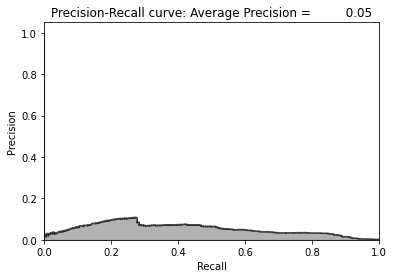

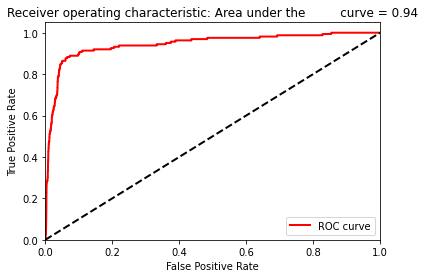

Epoch 1/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.2650 - accuracy: 0.6930 - val_loss: 0.0080 - val_accuracy: 0.9709
Epoch 2/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0406 - accuracy: 0.8611 - val_loss: 0.0061 - val_accuracy: 0.9735
Epoch 3/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.0404 - accuracy: 0.8626 - val_loss: 0.0066 - val_accuracy: 0.9779
Epoch 4/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0404 - accuracy: 0.8616 - val_loss: 0.0069 - val_accuracy: 0.9719
Epoch 5/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0410 - accuracy: 0.8605 - val_loss: 0.0043 - val_accuracy: 0.9830
Epoch 6/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0397 - accuracy: 0.8632 - val_loss: 0.0060 - val_accuracy: 0.9714
Epoch 7/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0397 - accuracy: 0.8628 - val_loss: 0.0105 - val_ac

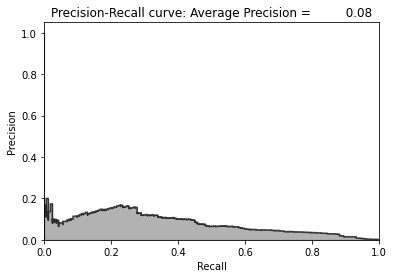

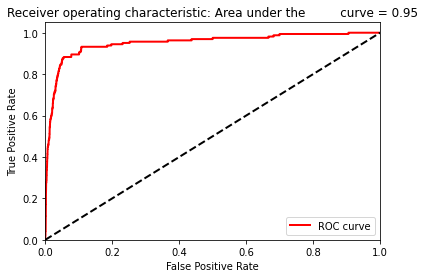

Epoch 1/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.2607 - accuracy: 0.6899 - val_loss: 0.0070 - val_accuracy: 0.9721
Epoch 2/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0409 - accuracy: 0.8624 - val_loss: 0.0050 - val_accuracy: 0.9787
Epoch 3/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0411 - accuracy: 0.8630 - val_loss: 0.0056 - val_accuracy: 0.9804
Epoch 4/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0394 - accuracy: 0.8636 - val_loss: 0.0079 - val_accuracy: 0.9681
Epoch 5/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0410 - accuracy: 0.8626 - val_loss: 0.0044 - val_accuracy: 0.9811
Epoch 6/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0391 - accuracy: 0.8650 - val_loss: 0.0055 - val_accuracy: 0.9747
Epoch 7/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0395 - accuracy: 0.8627 - val_loss: 0.0056 - val_accu

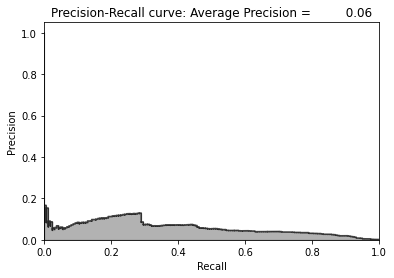

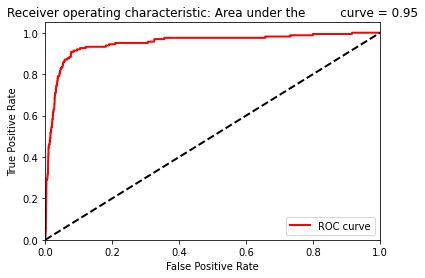

Epoch 1/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.2940 - accuracy: 0.6803 - val_loss: 0.0072 - val_accuracy: 0.9722
Epoch 2/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0401 - accuracy: 0.8616 - val_loss: 0.0058 - val_accuracy: 0.9759
Epoch 3/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0402 - accuracy: 0.8617 - val_loss: 0.0046 - val_accuracy: 0.9824
Epoch 4/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0403 - accuracy: 0.8620 - val_loss: 0.0066 - val_accuracy: 0.9695
Epoch 5/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0414 - accuracy: 0.8598 - val_loss: 0.0044 - val_accuracy: 0.9825
Epoch 6/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0394 - accuracy: 0.8613 - val_loss: 0.0062 - val_accuracy: 0.9695
Epoch 7/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0401 - accuracy: 0.8618 - val_loss: 0.0045 - val_accu

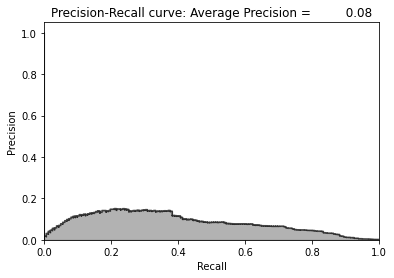

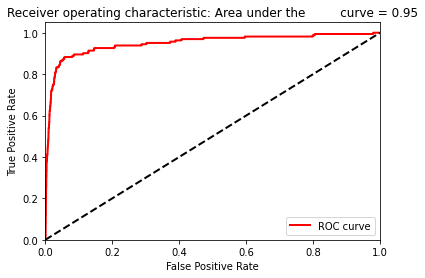

Epoch 1/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.2734 - accuracy: 0.6799 - val_loss: 0.0069 - val_accuracy: 0.9730
Epoch 2/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0411 - accuracy: 0.8605 - val_loss: 0.0047 - val_accuracy: 0.9819
Epoch 3/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0411 - accuracy: 0.8602 - val_loss: 0.0061 - val_accuracy: 0.9763
Epoch 4/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0388 - accuracy: 0.8619 - val_loss: 0.0091 - val_accuracy: 0.9727
Epoch 5/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0407 - accuracy: 0.8614 - val_loss: 0.0053 - val_accuracy: 0.9757
Epoch 6/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0388 - accuracy: 0.8645 - val_loss: 0.0049 - val_accuracy: 0.9802
Epoch 7/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0396 - accuracy: 0.8618 - val_loss: 0.0069 - val_accu

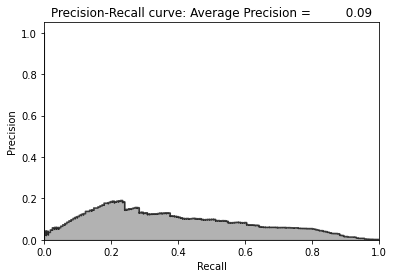

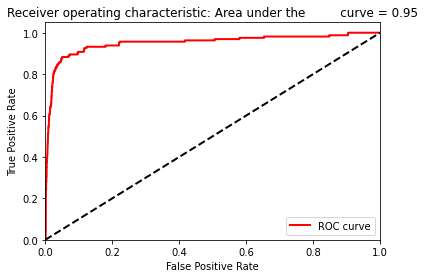

Epoch 1/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.2847 - accuracy: 0.6774 - val_loss: 0.0079 - val_accuracy: 0.9692
Epoch 2/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0421 - accuracy: 0.8606 - val_loss: 0.0047 - val_accuracy: 0.9814
Epoch 3/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0400 - accuracy: 0.8628 - val_loss: 0.0052 - val_accuracy: 0.9784
Epoch 4/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0395 - accuracy: 0.8626 - val_loss: 0.0061 - val_accuracy: 0.9715
Epoch 5/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0397 - accuracy: 0.8619 - val_loss: 0.0041 - val_accuracy: 0.9845
Epoch 6/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0396 - accuracy: 0.8624 - val_loss: 0.0073 - val_accuracy: 0.9717
Epoch 7/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0407 - accuracy: 0.8627 - val_loss: 0.0047 - val_ac

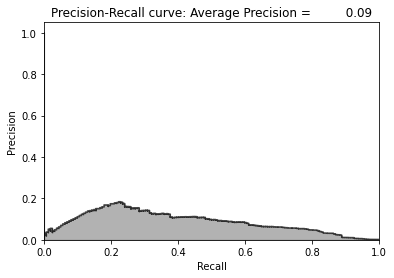

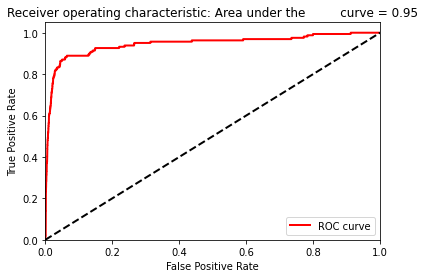

Epoch 1/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.2723 - accuracy: 0.6726 - val_loss: 0.0067 - val_accuracy: 0.9733
Epoch 2/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0417 - accuracy: 0.8606 - val_loss: 0.0048 - val_accuracy: 0.9803
Epoch 3/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0404 - accuracy: 0.8627 - val_loss: 0.0052 - val_accuracy: 0.9783
Epoch 4/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0392 - accuracy: 0.8631 - val_loss: 0.0080 - val_accuracy: 0.9717
Epoch 5/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0399 - accuracy: 0.8623 - val_loss: 0.0046 - val_accuracy: 0.9789
Epoch 6/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0400 - accuracy: 0.8624 - val_loss: 0.0056 - val_accuracy: 0.9738
Epoch 7/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0392 - accuracy: 0.8603 - val_loss: 0.0053 - val_accu

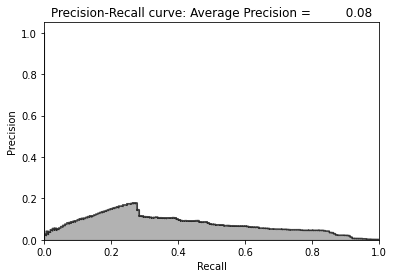

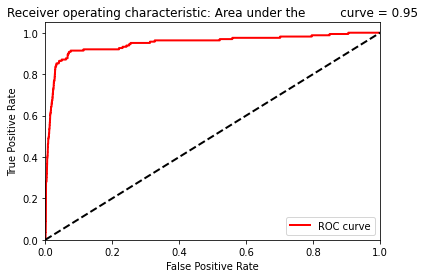

Epoch 1/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.2695 - accuracy: 0.7016 - val_loss: 0.0068 - val_accuracy: 0.9726
Epoch 2/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0400 - accuracy: 0.8629 - val_loss: 0.0051 - val_accuracy: 0.9790
Epoch 3/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0397 - accuracy: 0.8616 - val_loss: 0.0051 - val_accuracy: 0.9794
Epoch 4/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0398 - accuracy: 0.8621 - val_loss: 0.0068 - val_accuracy: 0.9743
Epoch 5/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.0420 - accuracy: 0.8609 - val_loss: 0.0041 - val_accuracy: 0.9842
Epoch 6/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.0392 - accuracy: 0.8639 - val_loss: 0.0055 - val_accuracy: 0.9759
Epoch 7/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0389 - accuracy: 0.8646 - val_loss: 0.0059 - val_ac

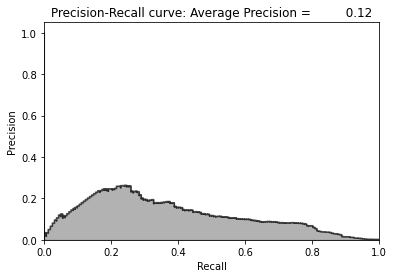

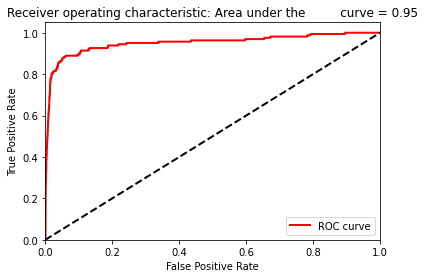

Epoch 1/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.2599 - accuracy: 0.6842 - val_loss: 0.0072 - val_accuracy: 0.9710
Epoch 2/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0419 - accuracy: 0.8613 - val_loss: 0.0052 - val_accuracy: 0.9771
Epoch 3/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0402 - accuracy: 0.8626 - val_loss: 0.0054 - val_accuracy: 0.9798
Epoch 4/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0391 - accuracy: 0.8613 - val_loss: 0.0052 - val_accuracy: 0.9772
Epoch 5/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0407 - accuracy: 0.8592 - val_loss: 0.0044 - val_accuracy: 0.9796
Epoch 6/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0391 - accuracy: 0.8611 - val_loss: 0.0050 - val_accuracy: 0.9770
Epoch 7/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0397 - accuracy: 0.8612 - val_loss: 0.0058 - val_ac

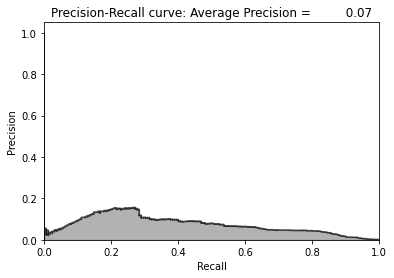

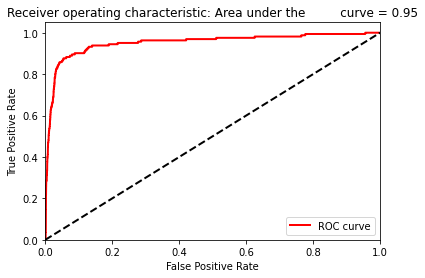

Epoch 1/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.2704 - accuracy: 0.6907 - val_loss: 0.0071 - val_accuracy: 0.9742
Epoch 2/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0416 - accuracy: 0.8629 - val_loss: 0.0044 - val_accuracy: 0.9821
Epoch 3/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0408 - accuracy: 0.8626 - val_loss: 0.0046 - val_accuracy: 0.9819
Epoch 4/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0392 - accuracy: 0.8639 - val_loss: 0.0078 - val_accuracy: 0.9720
Epoch 5/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0407 - accuracy: 0.8642 - val_loss: 0.0041 - val_accuracy: 0.9826
Epoch 6/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0399 - accuracy: 0.8634 - val_loss: 0.0051 - val_accuracy: 0.9781
Epoch 7/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0402 - accuracy: 0.8647 - val_loss: 0.0056 - val_ac

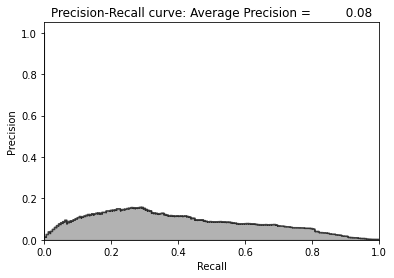

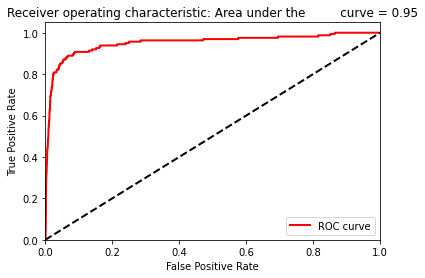

Mean average precision over 10 runs: 0.0798


[0.0522, 0.0791, 0.0592, 0.0826, 0.0863, 0.0864, 0.076, 0.1203, 0.073, 0.0831]

In [ ]:
# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    model.add(Dense(units=40, activation='linear',  \
        activity_regularizer=regularizers.l1(10e-5), input_dim=29))
    model.add(Dropout(0.05))

    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()
    
print(f"Mean average precision over 10 runs: {round(np.mean(test_scores),4)}")
[round(x,4) for x in test_scores]

## Results

In [ ]:
print(f'Mean average precision over 10 runs:   {round(np.mean(test_scores),4)}')
print(f'Coefficient of variation over 10 runs: {round(np.std(test_scores)/np.mean(test_scores),4)}')
[round(x,4) for x in test_scores]

Mean average precision over 10 runs:   0.0798
Coefficient of variation over 10 runs: 0.2169


[0.0522, 0.0791, 0.0592, 0.0826, 0.0863, 0.0864, 0.076, 0.1203, 0.073, 0.0831]

# Model Nine
## Two layer denoising undercomplete autoencoder with linear activation
## 29 -> 27 -> 29

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

: 

Epoch 1/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.3728 - accuracy: 0.6286 - val_loss: 0.0365 - val_accuracy: 0.8961
Epoch 2/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0556 - accuracy: 0.8654 - val_loss: 0.0362 - val_accuracy: 0.9092
Epoch 3/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0575 - accuracy: 0.8698 - val_loss: 0.0356 - val_accuracy: 0.8923
Epoch 4/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0546 - accuracy: 0.8712 - val_loss: 0.0365 - val_accuracy: 0.9097
Epoch 5/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0546 - accuracy: 0.8823 - val_loss: 0.0362 - val_accuracy: 0.9192
Epoch 6/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0544 - accuracy: 0.8865 - val_loss: 0.0372 - val_accuracy: 0.9112
Epoch 7/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0525 - accuracy: 0.8893 - val_loss: 0.0366 - val_accura

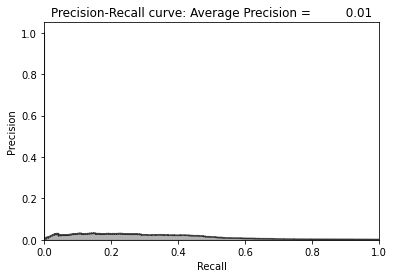

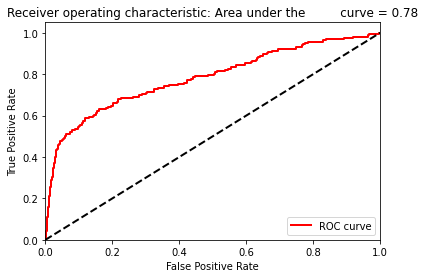

Epoch 1/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.3704 - accuracy: 0.6403 - val_loss: 0.0365 - val_accuracy: 0.9104
Epoch 2/10
5964/5964 [==============================] - 9s 1ms/step - loss: 0.0573 - accuracy: 0.8636 - val_loss: 0.0361 - val_accuracy: 0.9319
Epoch 3/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0591 - accuracy: 0.8747 - val_loss: 0.0358 - val_accuracy: 0.9499
Epoch 4/10
5964/5964 [==============================] - 9s 1ms/step - loss: 0.0524 - accuracy: 0.9036 - val_loss: 0.0368 - val_accuracy: 0.9374
Epoch 5/10
5964/5964 [==============================] - 9s 1ms/step - loss: 0.0538 - accuracy: 0.9004 - val_loss: 0.0357 - val_accuracy: 0.9457
Epoch 6/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0524 - accuracy: 0.9029 - val_loss: 0.0367 - val_accuracy: 0.9404
Epoch 7/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0540 - accuracy: 0.9029 - val_loss: 0.0370 - val_accuracy

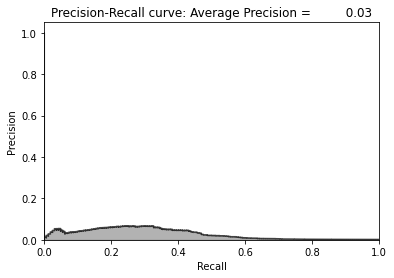

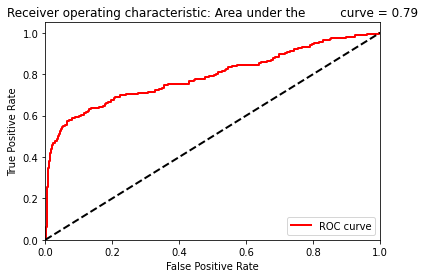

Epoch 1/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.3890 - accuracy: 0.6440 - val_loss: 0.0365 - val_accuracy: 0.9264
Epoch 2/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0565 - accuracy: 0.8926 - val_loss: 0.0362 - val_accuracy: 0.9441
Epoch 3/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0610 - accuracy: 0.9030 - val_loss: 0.0359 - val_accuracy: 0.9599
Epoch 4/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0546 - accuracy: 0.9153 - val_loss: 0.0372 - val_accuracy: 0.9500
Epoch 5/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0548 - accuracy: 0.9074 - val_loss: 0.0361 - val_accuracy: 0.9541
Epoch 6/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0536 - accuracy: 0.9081 - val_loss: 0.0375 - val_accuracy: 0.9440
Epoch 7/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0527 - accuracy: 0.9068 - val_loss: 0.0366 - val_accuracy

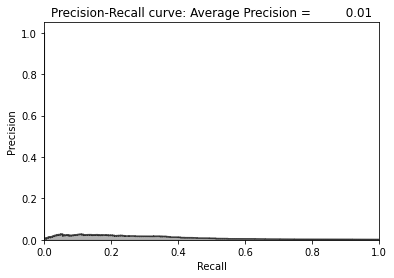

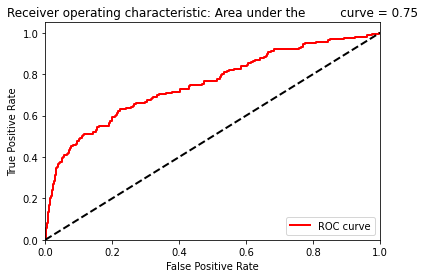

Epoch 1/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.3724 - accuracy: 0.6356 - val_loss: 0.0363 - val_accuracy: 0.9426
Epoch 2/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0564 - accuracy: 0.8992 - val_loss: 0.0369 - val_accuracy: 0.9578
Epoch 3/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0645 - accuracy: 0.9018 - val_loss: 0.0369 - val_accuracy: 0.9640
Epoch 4/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0544 - accuracy: 0.9136 - val_loss: 0.0382 - val_accuracy: 0.9544
Epoch 5/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0556 - accuracy: 0.9108 - val_loss: 0.0364 - val_accuracy: 0.9679
Epoch 6/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0535 - accuracy: 0.9121 - val_loss: 0.0371 - val_accuracy: 0.9533
Epoch 7/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0524 - accuracy: 0.9113 - val_loss: 0.0370 - val_accuracy

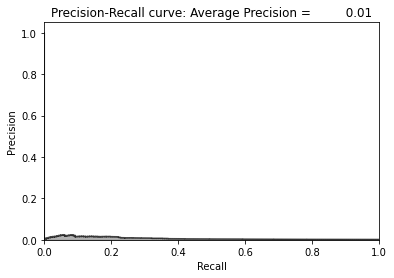

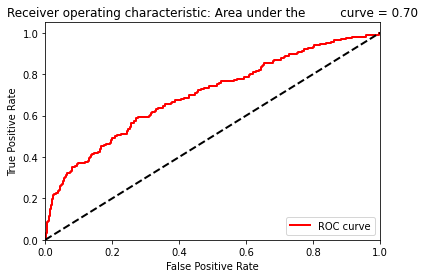

Epoch 1/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.3878 - accuracy: 0.6345 - val_loss: 0.0369 - val_accuracy: 0.9202
Epoch 2/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0572 - accuracy: 0.8875 - val_loss: 0.0371 - val_accuracy: 0.9387
Epoch 3/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0621 - accuracy: 0.8984 - val_loss: 0.0366 - val_accuracy: 0.9496
Epoch 4/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0557 - accuracy: 0.9120 - val_loss: 0.0379 - val_accuracy: 0.9516
Epoch 5/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0554 - accuracy: 0.9090 - val_loss: 0.0365 - val_accuracy: 0.9612
Epoch 6/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0538 - accuracy: 0.9080 - val_loss: 0.0372 - val_accuracy: 0.9482
Epoch 7/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0521 - accuracy: 0.9065 - val_loss: 0.0369 - val_accuracy

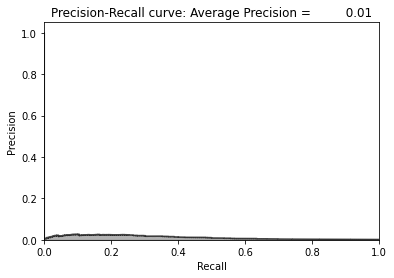

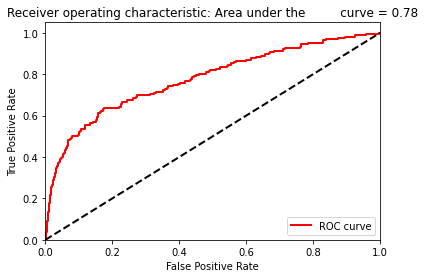

Epoch 1/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.3700 - accuracy: 0.6312 - val_loss: 0.0374 - val_accuracy: 0.8904
Epoch 2/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0556 - accuracy: 0.8438 - val_loss: 0.0362 - val_accuracy: 0.8682
Epoch 3/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0559 - accuracy: 0.8597 - val_loss: 0.0354 - val_accuracy: 0.9190
Epoch 4/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0538 - accuracy: 0.8852 - val_loss: 0.0363 - val_accuracy: 0.9333
Epoch 5/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0566 - accuracy: 0.8913 - val_loss: 0.0354 - val_accuracy: 0.9499
Epoch 6/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0525 - accuracy: 0.8981 - val_loss: 0.0361 - val_accuracy: 0.9404
Epoch 7/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0531 - accuracy: 0.8991 - val_loss: 0.0362 - val_accuracy

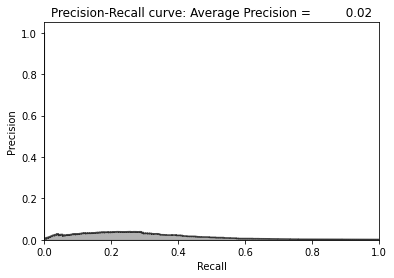

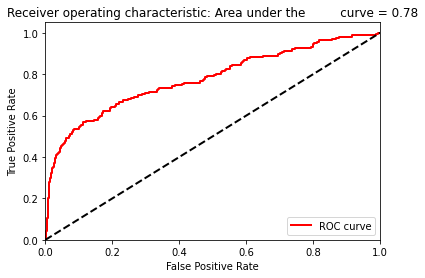

Epoch 1/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.3858 - accuracy: 0.6415 - val_loss: 0.0365 - val_accuracy: 0.8895
Epoch 2/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0552 - accuracy: 0.8550 - val_loss: 0.0357 - val_accuracy: 0.8995
Epoch 3/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0558 - accuracy: 0.8622 - val_loss: 0.0358 - val_accuracy: 0.8978
Epoch 4/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0536 - accuracy: 0.8653 - val_loss: 0.0363 - val_accuracy: 0.9072
Epoch 5/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0541 - accuracy: 0.8723 - val_loss: 0.0357 - val_accuracy: 0.9082
Epoch 6/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0534 - accuracy: 0.8799 - val_loss: 0.0359 - val_accuracy: 0.9071
Epoch 7/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0537 - accuracy: 0.8739 - val_loss: 0.0374 - val_accuracy

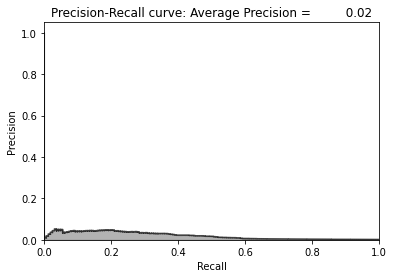

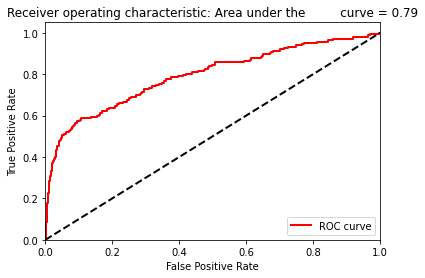

Epoch 1/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.4367 - accuracy: 0.6155 - val_loss: 0.0363 - val_accuracy: 0.9223
Epoch 2/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.0544 - accuracy: 0.8897 - val_loss: 0.0354 - val_accuracy: 0.9460
Epoch 3/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0534 - accuracy: 0.9031 - val_loss: 0.0353 - val_accuracy: 0.9479
Epoch 4/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0541 - accuracy: 0.9067 - val_loss: 0.0359 - val_accuracy: 0.9508
Epoch 5/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0556 - accuracy: 0.9073 - val_loss: 0.0356 - val_accuracy: 0.9597
Epoch 6/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0529 - accuracy: 0.9133 - val_loss: 0.0357 - val_accuracy: 0.9563
Epoch 7/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0546 - accuracy: 0.9143 - val_loss: 0.0367 - val_accurac

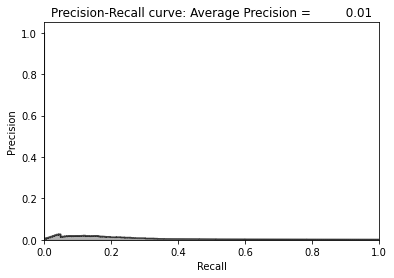

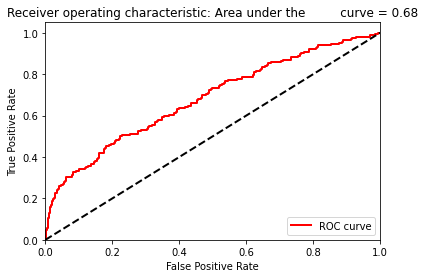

Epoch 1/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.3548 - accuracy: 0.6500 - val_loss: 0.0367 - val_accuracy: 0.9378
Epoch 2/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0565 - accuracy: 0.9002 - val_loss: 0.0369 - val_accuracy: 0.9587
Epoch 3/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0657 - accuracy: 0.9036 - val_loss: 0.0371 - val_accuracy: 0.9642
Epoch 4/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0552 - accuracy: 0.9156 - val_loss: 0.0377 - val_accuracy: 0.9593
Epoch 5/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0555 - accuracy: 0.9130 - val_loss: 0.0365 - val_accuracy: 0.9689
Epoch 6/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0535 - accuracy: 0.9129 - val_loss: 0.0370 - val_accuracy: 0.9566
Epoch 7/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0521 - accuracy: 0.9115 - val_loss: 0.0367 - val_accurac

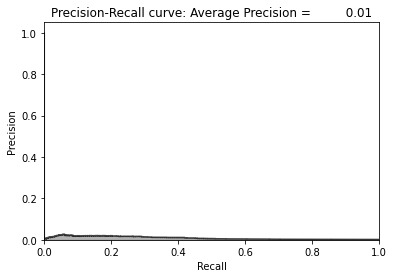

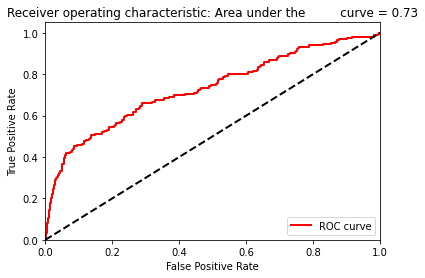

Epoch 1/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.3874 - accuracy: 0.6347 - val_loss: 0.0371 - val_accuracy: 0.9209
Epoch 2/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0567 - accuracy: 0.8791 - val_loss: 0.0367 - val_accuracy: 0.9159
Epoch 3/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0582 - accuracy: 0.8769 - val_loss: 0.0361 - val_accuracy: 0.9112
Epoch 4/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0554 - accuracy: 0.8828 - val_loss: 0.0382 - val_accuracy: 0.9209
Epoch 5/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0554 - accuracy: 0.8901 - val_loss: 0.0363 - val_accuracy: 0.9506
Epoch 6/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0537 - accuracy: 0.9039 - val_loss: 0.0382 - val_accuracy: 0.9413
Epoch 7/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.0527 - accuracy: 0.9042 - val_loss: 0.0375 - val_accurac

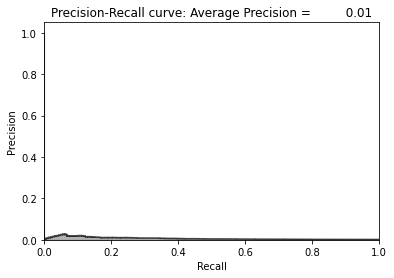

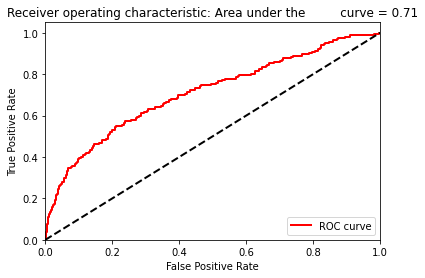

Mean average precision over 10 runs: 0.0131


[0.0148, 0.0279, 0.0106, 0.007, 0.0117, 0.0159, 0.02, 0.0068, 0.0092, 0.0071]

In [ ]:
# 10 runs - We will capture mean of average precision
test_scores = []

noise_factor = 0.50     #  how strong the noise
X_train_AE_noisy = X_train_AE.copy() + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train_AE.shape)
X_test_AE_noisy = X_test_AE.copy() + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test_AE.shape) 
    
for i in range(0,1):
    # Call neural network API
    model = Sequential()

    # Generate hidden layer with 27 nodes using linear activation
    model.add(Dense(units=27, activation='linear', input_dim=29))

    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE_noisy, y=X_train_AE_noisy,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test_AE_noisy, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    #model.reset_states()

print(f"Mean average precision over 10 runs: {round(np.mean(test_scores),4)}")
[round(x,4) for x in test_scores]

## Results

In [ ]:
print(f'Mean average precision over 10 runs:   {round(np.mean(test_scores),4)}')
print(f'Coefficient of variation over 10 runs: {round(np.std(test_scores)/np.mean(test_scores),4)}')
[round(x,4) for x in test_scores]

Mean average precision over 10 runs:   0.0131
Coefficient of variation over 10 runs: 0.4922


[0.0148, 0.0279, 0.0106, 0.007, 0.0117, 0.0159, 0.02, 0.0068, 0.0092, 0.0071]

# Model Ten
## Two layer denoising overcomplete autoencoder with linear activation
## And sparsity regularizer and dropout  
## 29 -> 40 -> 29  
## Dropout percentage: 5%

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

Epoch 1/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.2963 - accuracy: 0.6827 - val_loss: 0.0062 - val_accuracy: 0.9705
Epoch 2/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0508 - accuracy: 0.8486 - val_loss: 0.0049 - val_accuracy: 0.9806
Epoch 3/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0493 - accuracy: 0.8456 - val_loss: 0.0053 - val_accuracy: 0.9807
Epoch 4/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.0489 - accuracy: 0.8468 - val_loss: 0.0050 - val_accuracy: 0.9807
Epoch 5/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0502 - accuracy: 0.8471 - val_loss: 0.0041 - val_accuracy: 0.9803
Epoch 6/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0499 - accuracy: 0.8478 - val_loss: 0.0044 - val_accuracy: 0.9786
Epoch 7/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0490 - accuracy: 0.8485 - val_loss: 0.0045 - val_ac

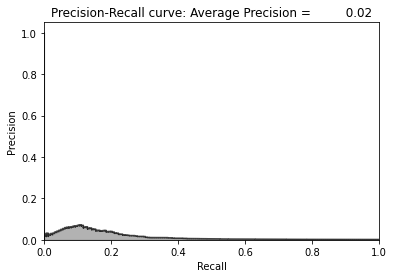

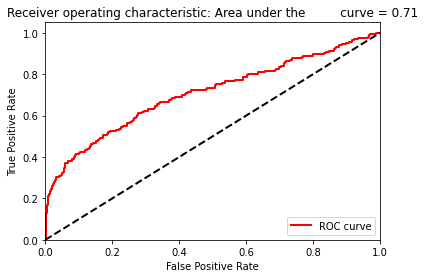

Epoch 1/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.3040 - accuracy: 0.6863 - val_loss: 0.0064 - val_accuracy: 0.9731
Epoch 2/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0502 - accuracy: 0.8487 - val_loss: 0.0060 - val_accuracy: 0.9738
Epoch 3/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0501 - accuracy: 0.8494 - val_loss: 0.0055 - val_accuracy: 0.9787
Epoch 4/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0500 - accuracy: 0.8475 - val_loss: 0.0059 - val_accuracy: 0.9749
Epoch 5/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0508 - accuracy: 0.8485 - val_loss: 0.0039 - val_accuracy: 0.9843
Epoch 6/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0497 - accuracy: 0.8482 - val_loss: 0.0051 - val_accuracy: 0.9750
Epoch 7/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0495 - accuracy: 0.8484 - val_loss: 0.0090 - val_ac

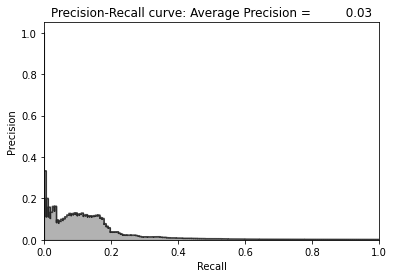

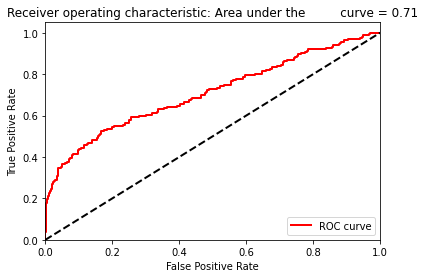

Epoch 1/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.2983 - accuracy: 0.6837 - val_loss: 0.0054 - val_accuracy: 0.9781
Epoch 2/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0504 - accuracy: 0.8485 - val_loss: 0.0047 - val_accuracy: 0.9787
Epoch 3/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0508 - accuracy: 0.8487 - val_loss: 0.0046 - val_accuracy: 0.9824
Epoch 4/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0492 - accuracy: 0.8493 - val_loss: 0.0067 - val_accuracy: 0.9716
Epoch 5/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0505 - accuracy: 0.8478 - val_loss: 0.0041 - val_accuracy: 0.9822
Epoch 6/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0490 - accuracy: 0.8507 - val_loss: 0.0048 - val_accuracy: 0.9758
Epoch 7/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0495 - accuracy: 0.8496 - val_loss: 0.0047 - val_ac

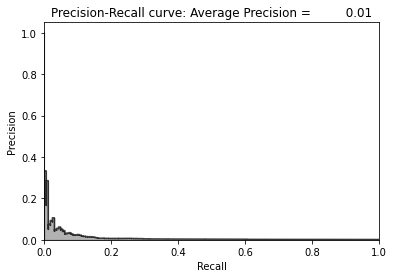

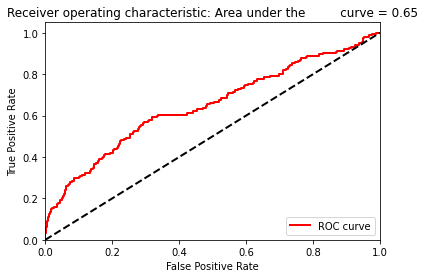

Epoch 1/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.3338 - accuracy: 0.6718 - val_loss: 0.0058 - val_accuracy: 0.9746
Epoch 2/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0496 - accuracy: 0.8503 - val_loss: 0.0055 - val_accuracy: 0.9764
Epoch 3/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0501 - accuracy: 0.8476 - val_loss: 0.0042 - val_accuracy: 0.9841
Epoch 4/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0501 - accuracy: 0.8474 - val_loss: 0.0058 - val_accuracy: 0.9726
Epoch 5/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.0508 - accuracy: 0.8491 - val_loss: 0.0042 - val_accuracy: 0.9829
Epoch 6/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0492 - accuracy: 0.8474 - val_loss: 0.0055 - val_accuracy: 0.9700
Epoch 7/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0495 - accuracy: 0.8476 - val_loss: 0.0042 - val_ac

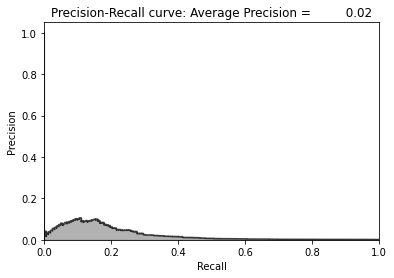

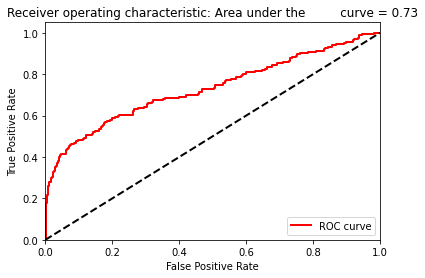

Epoch 1/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.3136 - accuracy: 0.6768 - val_loss: 0.0055 - val_accuracy: 0.9767
Epoch 2/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0506 - accuracy: 0.8476 - val_loss: 0.0043 - val_accuracy: 0.9822
Epoch 3/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0503 - accuracy: 0.8481 - val_loss: 0.0050 - val_accuracy: 0.9787
Epoch 4/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0486 - accuracy: 0.8493 - val_loss: 0.0072 - val_accuracy: 0.9763
Epoch 5/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0505 - accuracy: 0.8493 - val_loss: 0.0046 - val_accuracy: 0.9776
Epoch 6/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0488 - accuracy: 0.8478 - val_loss: 0.0043 - val_accuracy: 0.9819
Epoch 7/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0493 - accuracy: 0.8500 - val_loss: 0.0061 - val_ac

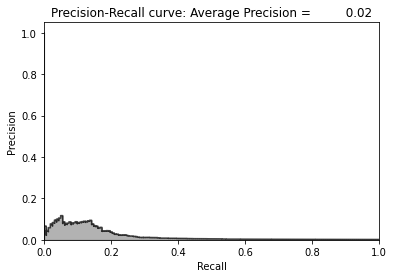

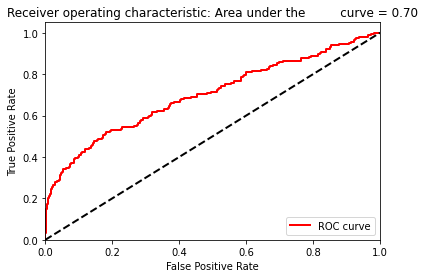

Epoch 1/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.3261 - accuracy: 0.6746 - val_loss: 0.0059 - val_accuracy: 0.9734
Epoch 2/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0514 - accuracy: 0.8482 - val_loss: 0.0044 - val_accuracy: 0.9813
Epoch 3/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0495 - accuracy: 0.8494 - val_loss: 0.0045 - val_accuracy: 0.9817
Epoch 4/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0492 - accuracy: 0.8488 - val_loss: 0.0052 - val_accuracy: 0.9743
Epoch 5/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0494 - accuracy: 0.8496 - val_loss: 0.0039 - val_accuracy: 0.9844
Epoch 6/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0493 - accuracy: 0.8498 - val_loss: 0.0059 - val_accuracy: 0.9753
Epoch 7/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0505 - accuracy: 0.8486 - val_loss: 0.0046 - val_ac

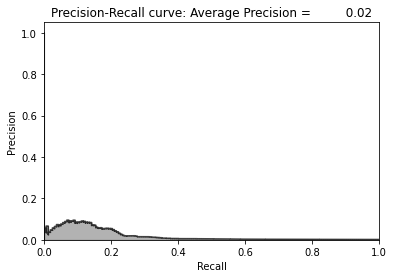

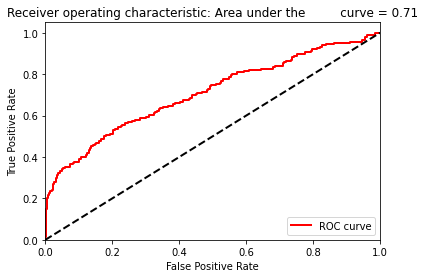

Epoch 1/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.3120 - accuracy: 0.6737 - val_loss: 0.0055 - val_accuracy: 0.9749
Epoch 2/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0512 - accuracy: 0.8498 - val_loss: 0.0044 - val_accuracy: 0.9818
Epoch 3/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0501 - accuracy: 0.8491 - val_loss: 0.0043 - val_accuracy: 0.9812
Epoch 4/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0490 - accuracy: 0.8498 - val_loss: 0.0069 - val_accuracy: 0.9743
Epoch 5/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.0497 - accuracy: 0.8485 - val_loss: 0.0043 - val_accuracy: 0.9814
Epoch 6/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0498 - accuracy: 0.8495 - val_loss: 0.0048 - val_accuracy: 0.9757
Epoch 7/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0489 - accuracy: 0.8485 - val_loss: 0.0044 - val_ac

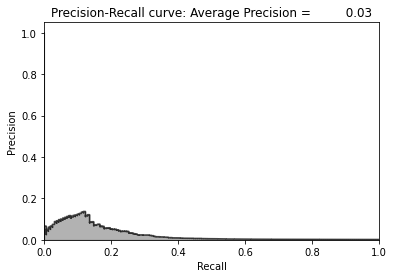

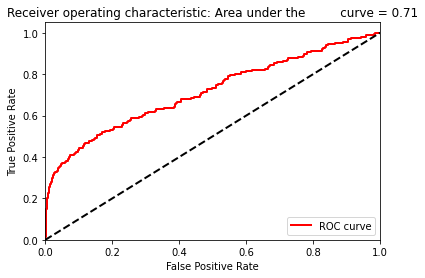

Epoch 1/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.3053 - accuracy: 0.6925 - val_loss: 0.0054 - val_accuracy: 0.9751
Epoch 2/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.0494 - accuracy: 0.8490 - val_loss: 0.0047 - val_accuracy: 0.9802
Epoch 3/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0496 - accuracy: 0.8483 - val_loss: 0.0044 - val_accuracy: 0.9819
Epoch 4/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0497 - accuracy: 0.8471 - val_loss: 0.0056 - val_accuracy: 0.9782
Epoch 5/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0519 - accuracy: 0.8466 - val_loss: 0.0038 - val_accuracy: 0.9854
Epoch 6/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0492 - accuracy: 0.8516 - val_loss: 0.0046 - val_accuracy: 0.9781
Epoch 7/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0487 - accuracy: 0.8492 - val_loss: 0.0055 - val_ac

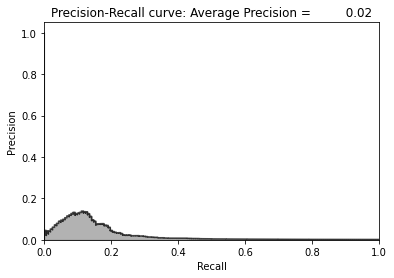

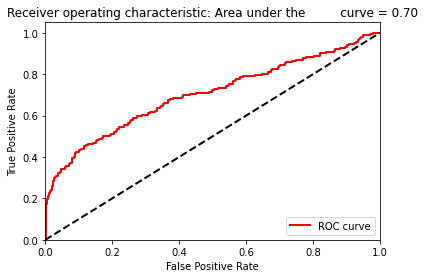

Epoch 1/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.2979 - accuracy: 0.6819 - val_loss: 0.0058 - val_accuracy: 0.9726
Epoch 2/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0512 - accuracy: 0.8480 - val_loss: 0.0047 - val_accuracy: 0.9785
Epoch 3/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0497 - accuracy: 0.8479 - val_loss: 0.0048 - val_accuracy: 0.9809
Epoch 4/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0490 - accuracy: 0.8472 - val_loss: 0.0046 - val_accuracy: 0.9799
Epoch 5/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0508 - accuracy: 0.8493 - val_loss: 0.0041 - val_accuracy: 0.9809
Epoch 6/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0492 - accuracy: 0.8489 - val_loss: 0.0043 - val_accuracy: 0.9799
Epoch 7/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0495 - accuracy: 0.8460 - val_loss: 0.0049 - val_ac

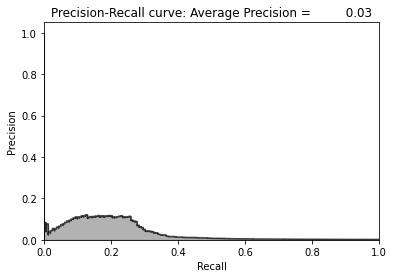

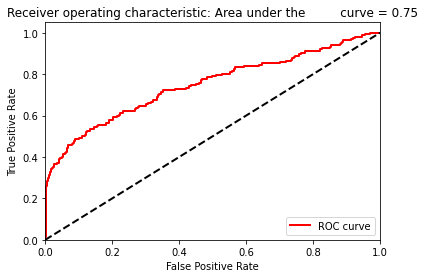

Epoch 1/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.3105 - accuracy: 0.6789 - val_loss: 0.0058 - val_accuracy: 0.9769
Epoch 2/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0511 - accuracy: 0.8462 - val_loss: 0.0041 - val_accuracy: 0.9823
Epoch 3/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0505 - accuracy: 0.8490 - val_loss: 0.0041 - val_accuracy: 0.9837
Epoch 4/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0488 - accuracy: 0.8497 - val_loss: 0.0066 - val_accuracy: 0.9733
Epoch 5/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0506 - accuracy: 0.8488 - val_loss: 0.0038 - val_accuracy: 0.9819
Epoch 6/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.0498 - accuracy: 0.8486 - val_loss: 0.0047 - val_accuracy: 0.9784
Epoch 7/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.0497 - accuracy: 0.8517 - val_loss: 0.0048 - val_ac

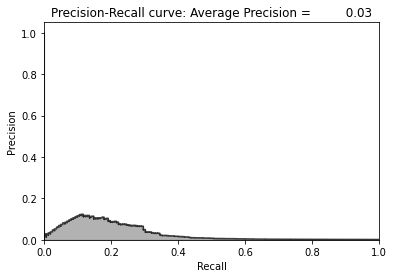

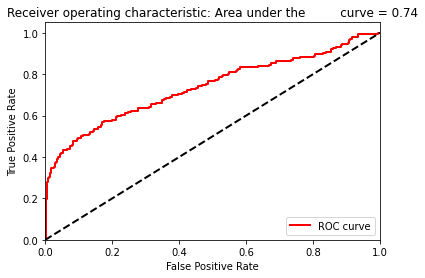

Mean average precision over 10 runs: 0.0239


[0.0155, 0.0307, 0.0122, 0.025, 0.0202, 0.02, 0.0257, 0.0244, 0.0343, 0.0308]

In [ ]:
# 10 runs - We will capture mean of average precision
test_scores = []

noise_factor = 0.50
X_train_AE_noisy = X_train_AE.copy() + noise_factor * \
 np.random.normal(loc=0.0, scale=1.0, size=X_train_AE.shape)
X_test_AE_noisy = X_test_AE.copy() + noise_factor * \
 np.random.normal(loc=0.0, scale=1.0, size=X_test_AE.shape) 
    
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    # Generate hidden layer with 40 nodes using linear activation
    model.add(Dense(units=40, activation='linear',  \
        activity_regularizer=regularizers.l1(10e-5), input_dim=29))
    model.add(Dropout(0.05))

    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE_noisy, y=X_train_AE_noisy,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test_AE_noisy, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()
    
print(f"Mean average precision over 10 runs: {round(np.mean(test_scores),4)}")
[round(x,4) for x in test_scores]

## Results

In [ ]:
print(f'Mean average precision over 10 runs:   {round(np.mean(test_scores),4)}')
print(f'Coefficient of variation over 10 runs: {round(np.std(test_scores)/np.mean(test_scores),4)}')
[round(x,4) for x in test_scores]

Mean average precision over 10 runs:   0.0239
Coefficient of variation over 10 runs: 0.2791


[0.0155, 0.0307, 0.0122, 0.025, 0.0202, 0.02, 0.0257, 0.0244, 0.0343, 0.0308]

# Model Eleven
## Two layer denoising overcomplete autoencoder with ReLU activation
## And sparsity regularizer and dropout  
## 29 -> 40 -> 29  
## Dropout percentage: 5%

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

Epoch 1/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.4365 - accuracy: 0.5372 - val_loss: 0.0228 - val_accuracy: 0.9172
Epoch 2/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.1360 - accuracy: 0.7204 - val_loss: 0.0184 - val_accuracy: 0.9130
Epoch 3/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.1267 - accuracy: 0.7291 - val_loss: 0.0152 - val_accuracy: 0.9225
Epoch 4/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.1177 - accuracy: 0.7337 - val_loss: 0.0155 - val_accuracy: 0.9174
Epoch 5/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.1180 - accuracy: 0.7330 - val_loss: 0.0128 - val_accuracy: 0.9232
Epoch 6/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.1175 - accuracy: 0.7349 - val_loss: 0.0135 - val_accuracy: 0.9229
Epoch 7/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.1147 - accuracy: 0.7363 - val_loss: 0.0128 - val_ac

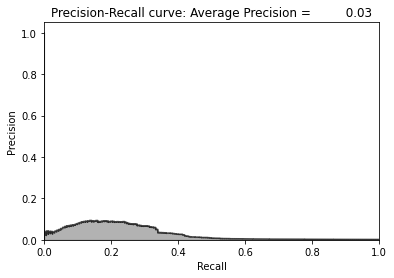

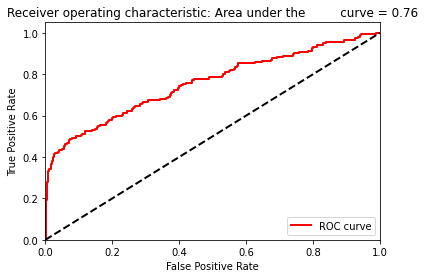

Epoch 1/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.4213 - accuracy: 0.5432 - val_loss: 0.0220 - val_accuracy: 0.9098
Epoch 2/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.1317 - accuracy: 0.7235 - val_loss: 0.0186 - val_accuracy: 0.9203
Epoch 3/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.1282 - accuracy: 0.7284 - val_loss: 0.0154 - val_accuracy: 0.9275
Epoch 4/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.1204 - accuracy: 0.7328 - val_loss: 0.0159 - val_accuracy: 0.9176
Epoch 5/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.1181 - accuracy: 0.7377 - val_loss: 0.0126 - val_accuracy: 0.9219
Epoch 6/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.1171 - accuracy: 0.7404 - val_loss: 0.0147 - val_accuracy: 0.9179
Epoch 7/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.1166 - accuracy: 0.7399 - val_loss: 0.0127 - val_ac

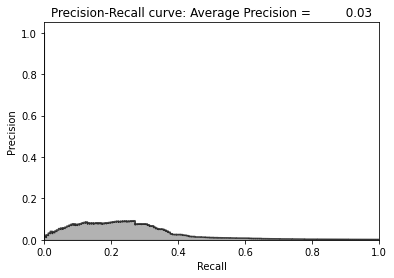

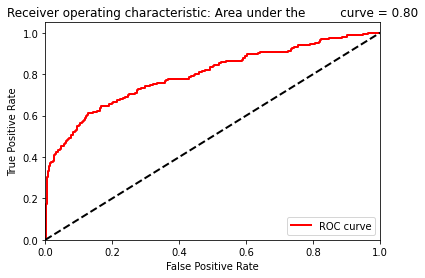

Epoch 1/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.4398 - accuracy: 0.5334 - val_loss: 0.0231 - val_accuracy: 0.9095
Epoch 2/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.1333 - accuracy: 0.7188 - val_loss: 0.0177 - val_accuracy: 0.9130
Epoch 3/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.1271 - accuracy: 0.7283 - val_loss: 0.0145 - val_accuracy: 0.9233
Epoch 4/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.1219 - accuracy: 0.7308 - val_loss: 0.0171 - val_accuracy: 0.9126
Epoch 5/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.1215 - accuracy: 0.7351 - val_loss: 0.0131 - val_accuracy: 0.9226
Epoch 6/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.1133 - accuracy: 0.7375 - val_loss: 0.0128 - val_accuracy: 0.9224
Epoch 7/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.1126 - accuracy: 0.7370 - val_loss: 0.0128 - val_ac

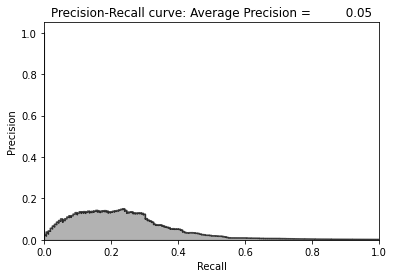

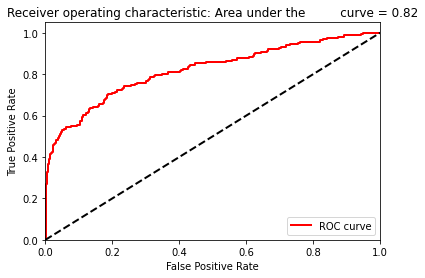

Epoch 1/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.4654 - accuracy: 0.5268 - val_loss: 0.0241 - val_accuracy: 0.9015
Epoch 2/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.1316 - accuracy: 0.7230 - val_loss: 0.0168 - val_accuracy: 0.9214
Epoch 3/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.1252 - accuracy: 0.7312 - val_loss: 0.0143 - val_accuracy: 0.9240
Epoch 4/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.1198 - accuracy: 0.7346 - val_loss: 0.0152 - val_accuracy: 0.9199
Epoch 5/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.1182 - accuracy: 0.7351 - val_loss: 0.0124 - val_accuracy: 0.9256
Epoch 6/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.1150 - accuracy: 0.7383 - val_loss: 0.0137 - val_accuracy: 0.9140
Epoch 7/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.1138 - accuracy: 0.7373 - val_loss: 0.0135 - val_ac

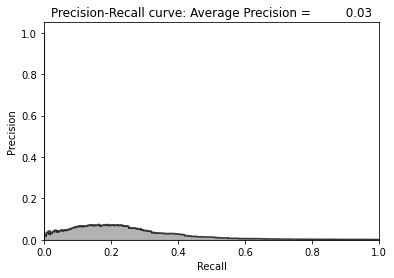

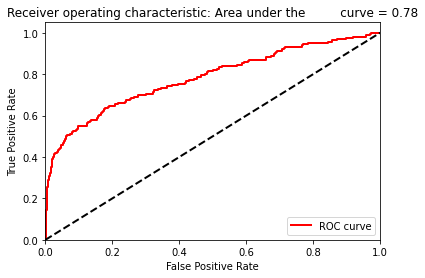

Epoch 1/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.4246 - accuracy: 0.5415 - val_loss: 0.0222 - val_accuracy: 0.9146
Epoch 2/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.1308 - accuracy: 0.7255 - val_loss: 0.0178 - val_accuracy: 0.9193
Epoch 3/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.1229 - accuracy: 0.7305 - val_loss: 0.0134 - val_accuracy: 0.9281
Epoch 4/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.1172 - accuracy: 0.7352 - val_loss: 0.0155 - val_accuracy: 0.9184
Epoch 5/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.1176 - accuracy: 0.7391 - val_loss: 0.0123 - val_accuracy: 0.9260
Epoch 6/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.1116 - accuracy: 0.7433 - val_loss: 0.0124 - val_accuracy: 0.9214
Epoch 7/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.1121 - accuracy: 0.7393 - val_loss: 0.0152 - val_ac

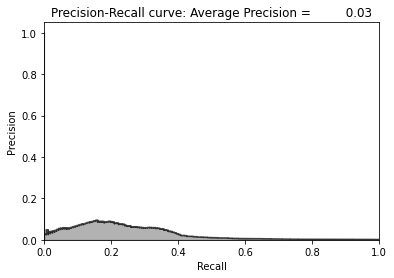

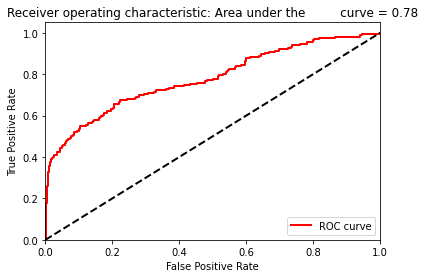

Epoch 1/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.4539 - accuracy: 0.5296 - val_loss: 0.0256 - val_accuracy: 0.9088
Epoch 2/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.1347 - accuracy: 0.7207 - val_loss: 0.0179 - val_accuracy: 0.9229
Epoch 3/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.1274 - accuracy: 0.7280 - val_loss: 0.0158 - val_accuracy: 0.9200
Epoch 4/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.1189 - accuracy: 0.7341 - val_loss: 0.0162 - val_accuracy: 0.9179
Epoch 5/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.1166 - accuracy: 0.7351 - val_loss: 0.0126 - val_accuracy: 0.9236
Epoch 6/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.1148 - accuracy: 0.7355 - val_loss: 0.0135 - val_accuracy: 0.9213
Epoch 7/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.1154 - accuracy: 0.7379 - val_loss: 0.0129 - val_ac

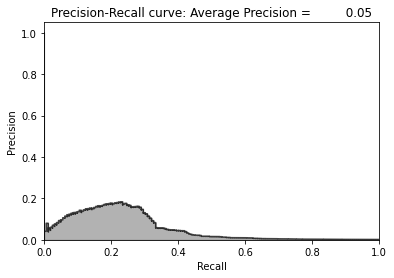

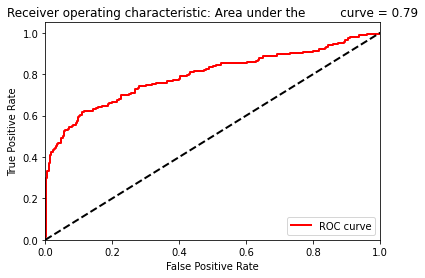

Epoch 1/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.4422 - accuracy: 0.5274 - val_loss: 0.0229 - val_accuracy: 0.9164
Epoch 2/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.1381 - accuracy: 0.7222 - val_loss: 0.0196 - val_accuracy: 0.9217
Epoch 3/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.1273 - accuracy: 0.7277 - val_loss: 0.0159 - val_accuracy: 0.9234
Epoch 4/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.1205 - accuracy: 0.7330 - val_loss: 0.0157 - val_accuracy: 0.9190
Epoch 5/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.1195 - accuracy: 0.7345 - val_loss: 0.0137 - val_accuracy: 0.9241
Epoch 6/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.1149 - accuracy: 0.7370 - val_loss: 0.0137 - val_accuracy: 0.9221
Epoch 7/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.1141 - accuracy: 0.7380 - val_loss: 0.0130 - val_ac

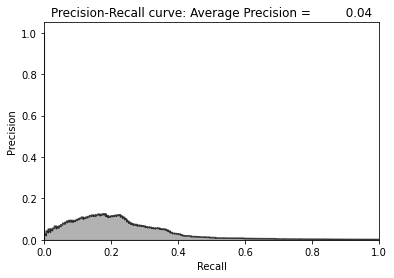

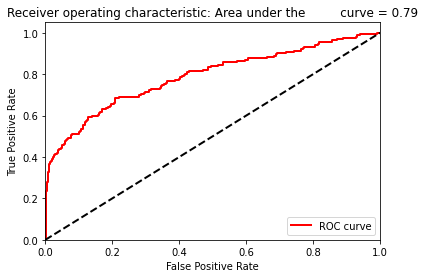

Epoch 1/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.4188 - accuracy: 0.5494 - val_loss: 0.0238 - val_accuracy: 0.9029
Epoch 2/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.1334 - accuracy: 0.7220 - val_loss: 0.0183 - val_accuracy: 0.9119
Epoch 3/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.1262 - accuracy: 0.7252 - val_loss: 0.0162 - val_accuracy: 0.9178
Epoch 4/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.1202 - accuracy: 0.7299 - val_loss: 0.0153 - val_accuracy: 0.9206
Epoch 5/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.1191 - accuracy: 0.7333 - val_loss: 0.0136 - val_accuracy: 0.9242
Epoch 6/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.1144 - accuracy: 0.7366 - val_loss: 0.0157 - val_accuracy: 0.9065
Epoch 7/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.1148 - accuracy: 0.7373 - val_loss: 0.0129 - val_ac

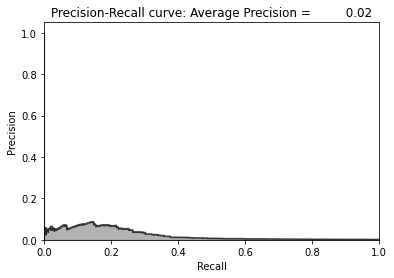

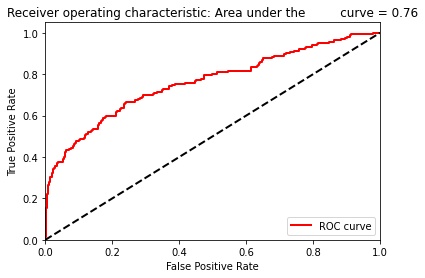

Epoch 1/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.4304 - accuracy: 0.5351 - val_loss: 0.0231 - val_accuracy: 0.9057
Epoch 2/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.1340 - accuracy: 0.7215 - val_loss: 0.0176 - val_accuracy: 0.9148
Epoch 3/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.1254 - accuracy: 0.7280 - val_loss: 0.0157 - val_accuracy: 0.9158
Epoch 4/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.1206 - accuracy: 0.7312 - val_loss: 0.0143 - val_accuracy: 0.9264
Epoch 5/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.1168 - accuracy: 0.7337 - val_loss: 0.0124 - val_accuracy: 0.9248
Epoch 6/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.1131 - accuracy: 0.7398 - val_loss: 0.0135 - val_accuracy: 0.9214
Epoch 7/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.1151 - accuracy: 0.7389 - val_loss: 0.0124 - val_ac

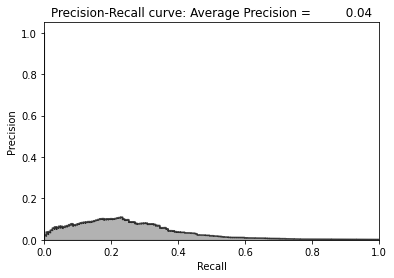

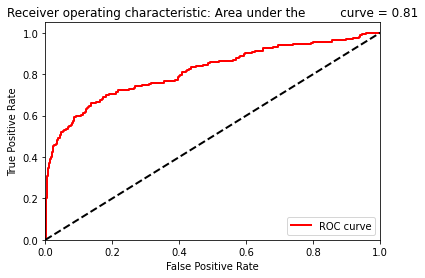

Epoch 1/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.4332 - accuracy: 0.5407 - val_loss: 0.0232 - val_accuracy: 0.9062
Epoch 2/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.1355 - accuracy: 0.7184 - val_loss: 0.0182 - val_accuracy: 0.9128
Epoch 3/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.1269 - accuracy: 0.7259 - val_loss: 0.0147 - val_accuracy: 0.9247
Epoch 4/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.1200 - accuracy: 0.7315 - val_loss: 0.0150 - val_accuracy: 0.9249
Epoch 5/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.1181 - accuracy: 0.7363 - val_loss: 0.0124 - val_accuracy: 0.9257
Epoch 6/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.1141 - accuracy: 0.7394 - val_loss: 0.0153 - val_accuracy: 0.9120
Epoch 7/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.1125 - accuracy: 0.7406 - val_loss: 0.0127 - val_ac

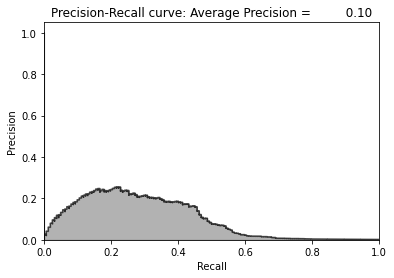

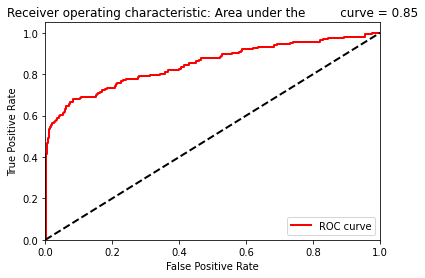

Mean average precision over 10 runs: 0.0417


[0.0301,
 0.0311,
 0.0495,
 0.0254,
 0.0294,
 0.0546,
 0.0368,
 0.0234,
 0.0366,
 0.1002]

In [51]:
# 10 runs - We will capture mean of average precision
test_scores = []

noise_factor = 0.50
X_train_AE_noisy = X_train_AE.copy() + noise_factor * \
 np.random.normal(loc=0.0, scale=1.0, size=X_train_AE.shape)
X_test_AE_noisy = X_test_AE.copy() + noise_factor * \
 np.random.normal(loc=0.0, scale=1.0, size=X_test_AE.shape) 
    
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    # Generate hidden layer with 40 nodes using linear activation
    model.add(Dense(units=40, activation='relu',  \
        activity_regularizer=regularizers.l1(10e-5), input_dim=29))
    model.add(Dropout(0.05))

    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE_noisy, y=X_train_AE_noisy,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test_AE_noisy, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()
    
print(f"Mean average precision over 10 runs: {round(np.mean(test_scores),4)}")
[round(x,4) for x in test_scores]

## Results

In [52]:
print(f'Mean average precision over 10 runs:   {round(np.mean(test_scores),4)}')
print(f'Coefficient of variation over 10 runs: {round(np.std(test_scores)/np.mean(test_scores),4)}')
[round(x,4) for x in test_scores]

Mean average precision over 10 runs:   0.0417
Coefficient of variation over 10 runs: 0.52


[0.0301,
 0.0311,
 0.0495,
 0.0254,
 0.0294,
 0.0546,
 0.0368,
 0.0234,
 0.0366,
 0.1002]

# Conclusion

In [53]:
import datetime as dt
print("Completed: ", dt.datetime.now())

Completed:  2021-05-06 15:56:19.284316
